In [1]:
#import all necessary packages
import pandas as pd
import hypernetx as hnx
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, fpmax
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import MaxNLocator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import math
from matplotlib.colors import BoundaryNorm, ListedColormap
from hypergraphx.measures.eigen_centralities import *

/Users/user/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Step 1. Generating Transactions from Mobility Dataset

In [2]:
# Path to the mobility dataframe with movements of 100,000 individuals over 75-day business as usual period
dataset_path = 'YJMob100k/yjmob100k-dataset2.csv' 
# The original dataset has 200x200 grid (area of a grid cell = 1/2 km x1/2 km = 0.25 km^2)
# Scaling_factor 10 (200/10 x 200/10) aggregates it to a 20x20 grid (area of a grid cell = 5 km x 5 km = 25 km^2)
scaling_factor = 10
# List of minimum support thresholds considered [1%, 1.5%, 2%]
min_sups = [0.005, 0.01, 0.015] #minimum support values corresponding to 1% and 1.5% respectively
deltaT_vals = [1, 3, 7] #Sliding window lengths

In [3]:
def read_transactions_from_file(filename):
    transactions = []
    
    with open(filename, "r") as f:
        for line in f:
            # Strip newline and split by commas to get pairs as strings
            pairs = line.strip().split("; ")
            
            # Convert each pair from string to a tuple of integers
            transaction = frozenset(
                tuple(map(int, pair.strip("()").split(","))) for pair in pairs
            )
            transactions.append(transaction)
    
    print(f"Loaded {len(transactions)} transactions from {filename}")
    return transactions

# Step 2. Computing Frequent Itemsets from Transactions Using FPGrowth

In [4]:
def read_freq_itemsets(deltaT, min_sup, file_path, details):
    # Define the filename based on deltaT and min_sup values
    filename = f"{file_path}freq_itemsets_deltaT_{deltaT}_minsup_{min_sup}_type_{details}.csv"
    
    try:
        # Read the CSV file
        freq_itemsets_df = pd.read_csv(filename)
        print(f"Successfully loaded {filename}")
        
        # Convert 'itemsets' column entries from frozenset string format to normal set
        def parse_to_set(item):
            # Remove 'frozenset({' and '})' to get the string representation of the set's contents
            item = item.strip("frozenset({})")
            
            # Now, split the string by '), (' to separate each tuple, then re-parse each tuple
            items = item.split("), (")
            
            # Convert each string tuple into an actual tuple and collect them into a set
            item_set = set()
            for i in items:
                # Convert each string (e.g., '13, 9') into a tuple (13, 9)
                item_set.add(tuple(map(int, i.split(", "))))
            
            return item_set

        # Apply the parsing function to the 'itemsets' column
        freq_itemsets_df['itemsets'] = freq_itemsets_df['itemsets'].apply(parse_to_set)
        freq_itemsets_df = freq_itemsets_df.reset_index(drop=True)
        return freq_itemsets_df
    except FileNotFoundError:
        print(f"Error: The file {filename} does not exist.")
        return None

In [5]:
# Test
file_path = "outputs/DS2/"
details = "emergency"
freq_itemsets = read_freq_itemsets(7, 0.015, file_path, details)
freq_itemsets = freq_itemsets.sort_values(by = 'support', ascending = False)
freq_itemsets.reset_index(drop = True)

Successfully loaded outputs/DS2/freq_itemsets_deltaT_7_minsup_0.015_type_emergency.csv


itemsets   support
0                       {(14, 8), (14, 9)}  0.167505
1                       {(13, 9), (14, 9)}  0.145348
2                       {(13, 9), (14, 8)}  0.137687
3                       {(13, 8), (14, 8)}  0.123134
4                       {(13, 8), (13, 9)}  0.115393
...                                    ...       ...
3547                    {(8, 14), (9, 13)}  0.015007
3548  {(16, 7), (17, 6), (17, 7), (17, 8)}  0.015007
3549                  {(18, 12), (19, 12)}  0.015002
3550          {(9, 12), (9, 13), (10, 12)}  0.015002
3551                  {(11, 12), (13, 13)}  0.015002

[3552 rows x 2 columns]

In [6]:
# Function to check if an itemset is a subset of another
def is_subset(itemset, other_itemset):
    return itemset.issubset(other_itemset)

In [7]:
# Filter for maximal itemsets
def filter_maximal_itemsets(freq_itemsets):
    max_freq_itemsets = []
    for i, row in freq_itemsets.iterrows():
        is_maximal = True
        for j, other_row in freq_itemsets.iterrows():
            if i != j and is_subset(row['itemsets'], other_row['itemsets']):
                is_maximal = False
                break
        if is_maximal:
            max_freq_itemsets.append((row['itemsets'], row['support']))

    # Create a new dataframe with maximal itemsets
    max_freq_itemsets_df = pd.DataFrame(max_freq_itemsets, columns=['itemsets', 'support'])
    return max_freq_itemsets_df

# Step 3. Constructing Hypergraphs from Frequent Itemsets

In [12]:
def construct_hypergraph_from_frequent_itemsets(frequent_itemsets):
    # Extract itemsets and supports
    hyperedges = frequent_itemsets['itemsets'].tolist()
    supports = frequent_itemsets['support'].tolist()
    
    # Construct dictionary for hypergraph with just nodes per edge initially
    hypergraph_dict = {f"{i}": list(edge) for i, edge in enumerate(hyperedges)}
    
    # Create hypergraph
    H = hnx.Hypergraph(hypergraph_dict)
    
    # Add weights to edges in the hypergraph
    for i, support in enumerate(supports):
        H.edges[f"{i}"].weight = support  # Assign weights after hypergraph is constructed

    # Print some info for verification
    print("(#nodes, #edges): ", H.shape)
    
    #Calculate connected components for verification
    #components = H.s_connected_components(edges=True, return_singletons=True)
    #component_sizes = [len(comp) for comp in components]
    #component_sizes = sorted(component_sizes, reverse=True)
    
    #print("# Components: ", len(component_sizes))
    #print("Component sizes:", component_sizes)

    return H, hyperedges

In [13]:
def construct_hypergraphs_loop(details):
    HG = {}
    HG_edges = {}
    count = 0
    for deltaT in deltaT_vals:
        count += 1
        HG[deltaT] = []
        HG_edges[deltaT] = []
        for min_sup in min_sups:
            print(f"Delta T = {deltaT} and min_sup = {min_sup}")
            freq_itemsets = read_freq_itemsets(deltaT, min_sup, file_path, details)
            print(f"#freq. itemsets = {len(freq_itemsets)}")
            hg, hg_edges = construct_hypergraph_from_frequent_itemsets(freq_itemsets)
            HG[deltaT].append(hg)
            HG_edges[deltaT].append(hg_edges)
            print(f"###########Constructed hypergraph for Delta T = {deltaT} and min_sup = {min_sup} ######")
    return HG, HG_edges

In [14]:
details = "regular"
HG_reg, HG_reg_edges = construct_hypergraphs_loop(details)

Delta T = 1 and min_sup = 0.005
Successfully loaded outputs/DS2/freq_itemsets_deltaT_1_minsup_0.005_type_regular.csv
#freq. itemsets = 465
(#nodes, #edges):  (136, 465)
###########Constructed hypergraph for Delta T = 1 and min_sup = 0.005 ######
Delta T = 1 and min_sup = 0.01
Successfully loaded outputs/DS2/freq_itemsets_deltaT_1_minsup_0.01_type_regular.csv
#freq. itemsets = 112
(#nodes, #edges):  (58, 112)
###########Constructed hypergraph for Delta T = 1 and min_sup = 0.01 ######
Delta T = 1 and min_sup = 0.015
Successfully loaded outputs/DS2/freq_itemsets_deltaT_1_minsup_0.015_type_regular.csv
#freq. itemsets = 39
(#nodes, #edges):  (31, 39)
###########Constructed hypergraph for Delta T = 1 and min_sup = 0.015 ######
Delta T = 3 and min_sup = 0.005
Successfully loaded outputs/DS2/freq_itemsets_deltaT_3_minsup_0.005_type_regular.csv
#freq. itemsets = 5018


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (208, 5018)
###########Constructed hypergraph for Delta T = 3 and min_sup = 0.005 ######
Delta T = 3 and min_sup = 0.01
Successfully loaded outputs/DS2/freq_itemsets_deltaT_3_minsup_0.01_type_regular.csv
#freq. itemsets = 1289
(#nodes, #edges):  (154, 1289)
###########Constructed hypergraph for Delta T = 3 and min_sup = 0.01 ######
Delta T = 3 and min_sup = 0.015


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

Successfully loaded outputs/DS2/freq_itemsets_deltaT_3_minsup_0.015_type_regular.csv
#freq. itemsets = 531
(#nodes, #edges):  (108, 531)
###########Constructed hypergraph for Delta T = 3 and min_sup = 0.015 ######
Delta T = 7 and min_sup = 0.005
Successfully loaded outputs/DS2/freq_itemsets_deltaT_7_minsup_0.005_type_regular.csv


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future 

#freq. itemsets = 72181


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (238, 72181)
###########Constructed hypergraph for Delta T = 7 and min_sup = 0.005 ######
Delta T = 7 and min_sup = 0.01
Successfully loaded outputs/DS2/freq_itemsets_deltaT_7_minsup_0.01_type_regular.csv
#freq. itemsets = 13470


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (200, 13470)
###########Constructed hypergraph for Delta T = 7 and min_sup = 0.01 ######
Delta T = 7 and min_sup = 0.015
Successfully loaded outputs/DS2/freq_itemsets_deltaT_7_minsup_0.015_type_regular.csv
#freq. itemsets = 4930


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (165, 4930)
###########Constructed hypergraph for Delta T = 7 and min_sup = 0.015 ######


In [15]:
details = "emergency"
HG_emg, HG_emg_edges = construct_hypergraphs_loop(details)

Delta T = 1 and min_sup = 0.005
Successfully loaded outputs/DS2/freq_itemsets_deltaT_1_minsup_0.005_type_emergency.csv
#freq. itemsets = 374
(#nodes, #edges):  (123, 374)
###########Constructed hypergraph for Delta T = 1 and min_sup = 0.005 ######
Delta T = 1 and min_sup = 0.01
Successfully loaded outputs/DS2/freq_itemsets_deltaT_1_minsup_0.01_type_emergency.csv
#freq. itemsets = 90
(#nodes, #edges):  (53, 90)
###########Constructed hypergraph for Delta T = 1 and min_sup = 0.01 ######
Delta T = 1 and min_sup = 0.015
Successfully loaded outputs/DS2/freq_itemsets_deltaT_1_minsup_0.015_type_emergency.csv
#freq. itemsets = 26
(#nodes, #edges):  (21, 26)
###########Constructed hypergraph for Delta T = 1 and min_sup = 0.015 ######
Delta T = 3 and min_sup = 0.005
Successfully loaded outputs/DS2/freq_itemsets_deltaT_3_minsup_0.005_type_emergency.csv
#freq. itemsets = 3861


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (200, 3861)
###########Constructed hypergraph for Delta T = 3 and min_sup = 0.005 ######
Delta T = 3 and min_sup = 0.01
Successfully loaded outputs/DS2/freq_itemsets_deltaT_3_minsup_0.01_type_emergency.csv
#freq. itemsets = 996
(#nodes, #edges):  (141, 996)
###########Constructed hypergraph for Delta T = 3 and min_sup = 0.01 ######
Delta T = 3 and min_sup = 0.015
Successfully loaded outputs/DS2/freq_itemsets_deltaT_3_minsup_0.015_type_emergency.csv
#freq. itemsets = 419


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (99, 419)
###########Constructed hypergraph for Delta T = 3 and min_sup = 0.015 ######
Delta T = 7 and min_sup = 0.005
Successfully loaded outputs/DS2/freq_itemsets_deltaT_7_minsup_0.005_type_emergency.csv
#freq. itemsets = 47945


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (240, 47945)
###########Constructed hypergraph for Delta T = 7 and min_sup = 0.005 ######
Delta T = 7 and min_sup = 0.01
Successfully loaded outputs/DS2/freq_itemsets_deltaT_7_minsup_0.01_type_emergency.csv
#freq. itemsets = 9454


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (197, 9454)
###########Constructed hypergraph for Delta T = 7 and min_sup = 0.01 ######
Delta T = 7 and min_sup = 0.015
Successfully loaded outputs/DS2/freq_itemsets_deltaT_7_minsup_0.015_type_emergency.csv
#freq. itemsets = 3552


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(#nodes, #edges):  (164, 3552)
###########Constructed hypergraph for Delta T = 7 and min_sup = 0.015 ######


In [16]:
def create_exclusive_hypergraphs(HG, HG_edges):
    # Create a list to store the exclusive hypergraphs
    exclusive_HG = {}

    for deltaT in HG_edges.keys():
        print(deltaT)
        exclusive_HG[deltaT] = []
        for i in range(0, len(HG_edges[deltaT])):
            hg_edges_i = HG_edges[deltaT][i]
            current_edges = set(tuple(sorted(edge)) for edge in hg_edges_i)
            for j in range(i+1, len(HG_edges[deltaT])):
                hg_edges_j = HG_edges[deltaT][j]
                current_edges -= set(tuple(sorted(edge)) for edge in hg_edges_j)
     
            exc_hg = hnx.Hypergraph({f"{i}": list(edge) for i, edge in enumerate(current_edges)})
  
            print(f"Number of edges exclusive for DeltaT = {deltaT} and min_sup = {min_sups[i]} are: {len(current_edges)}")
            exclusive_HG[deltaT].append(exc_hg)

    return exclusive_HG

In [17]:
exclusive_HG_reg = create_exclusive_hypergraphs(HG_reg, HG_reg_edges)

1
Number of edges exclusive for DeltaT = 1 and min_sup = 0.005 are: 353
Number of edges exclusive for DeltaT = 1 and min_sup = 0.01 are: 73
Number of edges exclusive for DeltaT = 1 and min_sup = 0.015 are: 39
3
Number of edges exclusive for DeltaT = 3 and min_sup = 0.005 are: 3729
Number of edges exclusive for DeltaT = 3 and min_sup = 0.01 are: 758
Number of edges exclusive for DeltaT = 3 and min_sup = 0.015 are: 531
7


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

Number of edges exclusive for DeltaT = 7 and min_sup = 0.005 are: 58711
Number of edges exclusive for DeltaT = 7 and min_sup = 0.01 are: 8540
Number of edges exclusive for DeltaT = 7 and min_sup = 0.015 are: 4930


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/p

In [18]:
exclusive_HG_emg = create_exclusive_hypergraphs(HG_emg, HG_emg_edges)

1
Number of edges exclusive for DeltaT = 1 and min_sup = 0.005 are: 284
Number of edges exclusive for DeltaT = 1 and min_sup = 0.01 are: 64
Number of edges exclusive for DeltaT = 1 and min_sup = 0.015 are: 26
3
Number of edges exclusive for DeltaT = 3 and min_sup = 0.005 are: 2865
Number of edges exclusive for DeltaT = 3 and min_sup = 0.01 are: 577
Number of edges exclusive for DeltaT = 3 and min_sup = 0.015 are: 419
7


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

Number of edges exclusive for DeltaT = 7 and min_sup = 0.005 are: 38491
Number of edges exclusive for DeltaT = 7 and min_sup = 0.01 are: 5902
Number of edges exclusive for DeltaT = 7 and min_sup = 0.015 are: 3552


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/p

In [19]:
exclusive_HG_reg_minsup = exclusive_HG_reg[1]
print(exclusive_HG_reg_minsup[1].shape)
for edge_id in exclusive_HG_reg_minsup[1].edges():
    print(edge_id, exclusive_HG_reg_minsup[1].edges[edge_id])

(57, 73)
0 [(10, 3), (11, 4)]
1 [(15, 11), (15, 12)]
10 [(13, 10), (13, 11)]
11 [(9, 3), (10, 3)]
12 [(17, 6), (18, 6)]
13 [(10, 12), (11, 11)]
14 [(14, 8), (16, 7)]
15 [(18, 5), (19, 6)]
16 [(11, 9), (11, 10)]
17 [(16, 7), (16, 8)]
18 [(9, 12), (10, 12)]
19 [(13, 10), (14, 8)]
2 [(12, 10), (13, 9)]
20 [(14, 11), (15, 11)]
21 [(14, 8), (14, 10)]
22 [(12, 7), (13, 7)]
23 [(13, 9), (14, 10)]
24 [(14, 8), (15, 7)]
25 [(15, 10), (15, 11)]
26 [(15, 8), (16, 9)]
27 [(13, 8), (14, 8), (14, 9)]
28 [(12, 13), (12, 14)]
29 [(13, 7), (14, 7)]
3 [(14, 7), (15, 7)]
30 [(11, 13), (12, 13)]
31 [(13, 8), (14, 7)]
32 [(15, 10), (16, 11)]
33 [(12, 7), (12, 8)]
34 [(10, 12), (11, 12)]
35 [(13, 11), (14, 11)]
36 [(14, 8), (14, 9), (14, 10)]
37 [(16, 8), (17, 8)]
38 [(13, 10), (14, 9)]
39 [(11, 8), (11, 9)]
4 [(18, 6), (19, 6)]
40 [(13, 6), (13, 7)]
41 [(12, 8), (13, 9)]
42 [(13, 8), (13, 9), (14, 8)]
43 [(15, 9), (16, 10)]
44 [(16, 10), (16, 11)]
45 [(11, 10), (11, 11)]
46 [(12, 8), (12, 9)]
47 [(16, 6), 

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()


# Step 4. Plot hypergraphs on spatial grid

In [20]:
def filter_higher_order_hyperedges(HG, min_size):
    """
    Filters the hypergraph to create a subhypergraph containing only hyperedges of size >= min_size.
    
    Parameters:
    HG (hnx.Hypergraph): The original hypergraph.
    min_size (int): The minimum size of hyperedges to include in the subhypergraph (default is 3).
    
    Returns:
    hnx.Hypergraph: A new hypergraph containing only the filtered hyperedges.
    """
    # Filter the hyperedges based on their size
    filtered_edges = {}
    for e in HG.edges:
        e_members = HG.edges[e]
        if len(e_members) >= min_size:
            #print(HG.edges[e])
            filtered_edges[e] = list(e_members)
    # Create and return a new subhypergraph
    return hnx.Hypergraph(filtered_edges)

In [21]:
import hypernetx as hnx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # For custom legend entries

def plot_hypergraphs_with_colored_edges(HG, plot_path, edge_widths, init_radius, 
                                        rad_factor, colors, alpha_values, 
                                        legend_text, DeltaT, details, min_size):
    # Create the figure and axis
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(111)

    # Define the grid size range from 1 to 20
    grid_min, grid_max = 1, 20
    grid_color = 'lightgray'

    # Set axis limits to ensure the grid is between 1 and 20, with a little padding for the box
    ax.set_xlim(grid_min - 0.5, grid_max + 0.5)
    ax.set_ylim(grid_min - 0.5, grid_max + 0.5)

    # Add grid lines from 1 to 20, ensuring they stay within the box
    ax.vlines(range(grid_min, grid_max + 1), grid_min, grid_max, color=grid_color, linestyle='-', linewidth=1, zorder=0)
    ax.hlines(range(grid_min, grid_max + 1), grid_min, grid_max, color=grid_color, linestyle='-', linewidth=1, zorder=0)

    # Add tick marks on the axes
    for i in range(grid_min, grid_max + 1):
        ax.text(i, grid_min - 0.5, str(i), ha='center', va='top', fontsize=10)  # X-axis labels
        ax.text(grid_min - 0.5, i, str(i), ha='right', va='center', fontsize=10)  # Y-axis labels

    # Configure node labels
    node_labels_kwargs = {
        'fontsize': 4,
        'color': 'k',
        'verticalalignment': 'best',
        'horizontalalignment': 'best',
    }

    # Determine node positions directly from coordinates in node identifiers
    node_set = {node for hypergraph in HG for node in hypergraph.nodes}
    pos = {node: (node[0], node[1]) for node in node_set}

    # Define distinct colors and edge widths for each layer based on support ranges


    # Draw each hypergraph with distinct colors and add a legend
    for i, H in enumerate(HG):
        H_sub = filter_higher_order_hyperedges(H, min_size)
        print(H_sub.shape)
        if H_sub.shape[0] == 0:
            print("0 nodes")
            continue
   
        facecolor_value = (0, 0, 0, alpha_values[i])  # Black face color with variable alpha
        edgecolor_value = colors[i]  # Assign distinct color for each hypergraph layer

        # Draw the hypergraph
        hnx.draw(H_sub, ax=ax, pos=pos, with_edge_labels=False, with_node_labels=False,
                 node_radius=init_radius + math.pow(i, 2) * rad_factor, node_labels_kwargs=node_labels_kwargs,
                 edges_kwargs={'edgecolor': edgecolor_value, 'facecolor': facecolor_value, 'linewidth': edge_widths[i]})

    legend_elements = [Line2D([0], [0], color=colors[i], lw=edge_widths[i], label=legend_text[i])
                       for i in range(len(HG))]

    # Customize the font size of the legend and title
    ax.legend(handles=legend_elements, title="Hypergraph edges by support ranges", loc="upper right",
              fontsize=12, title_fontsize=14)

    # Set the title font size and style
    plt.title(f'Co-visitation Hypergraph for $\Delta T = ${DeltaT} day(s) (DS2, {details} days)', fontsize=16, fontweight='bold')

    # Ensure the spines (top, bottom, left, right) are visible and have proper line width
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)  # Set the line width to make it more prominent

    # Remove default grid and adjust layout
    plt.grid(False)
    plt.tight_layout()

    # Save and display the plot
    plt.savefig(plot_path, dpi=600)
    plt.show()

# Example usage:
# plot_hypergraphs_with_colored_edges(HG, 'hypergraphs_distinct_colors.png')


<>:68: DeprecationWarning: invalid escape sequence \D
<>:68: DeprecationWarning: invalid escape sequence \D
/var/folders/z0/wy551r2j0yx_cykzvy1n6hq40000gp/T/ipykernel_22713/3355377321.py:68: DeprecationWarning: invalid escape sequence \D
  plt.title(f'Co-visitation Hypergraph for $\Delta T = ${DeltaT} day(s) (DS2, {details} days)', fontsize=16, fontweight='bold')


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/p

(32, 61)
(7, 6)
(3, 1)


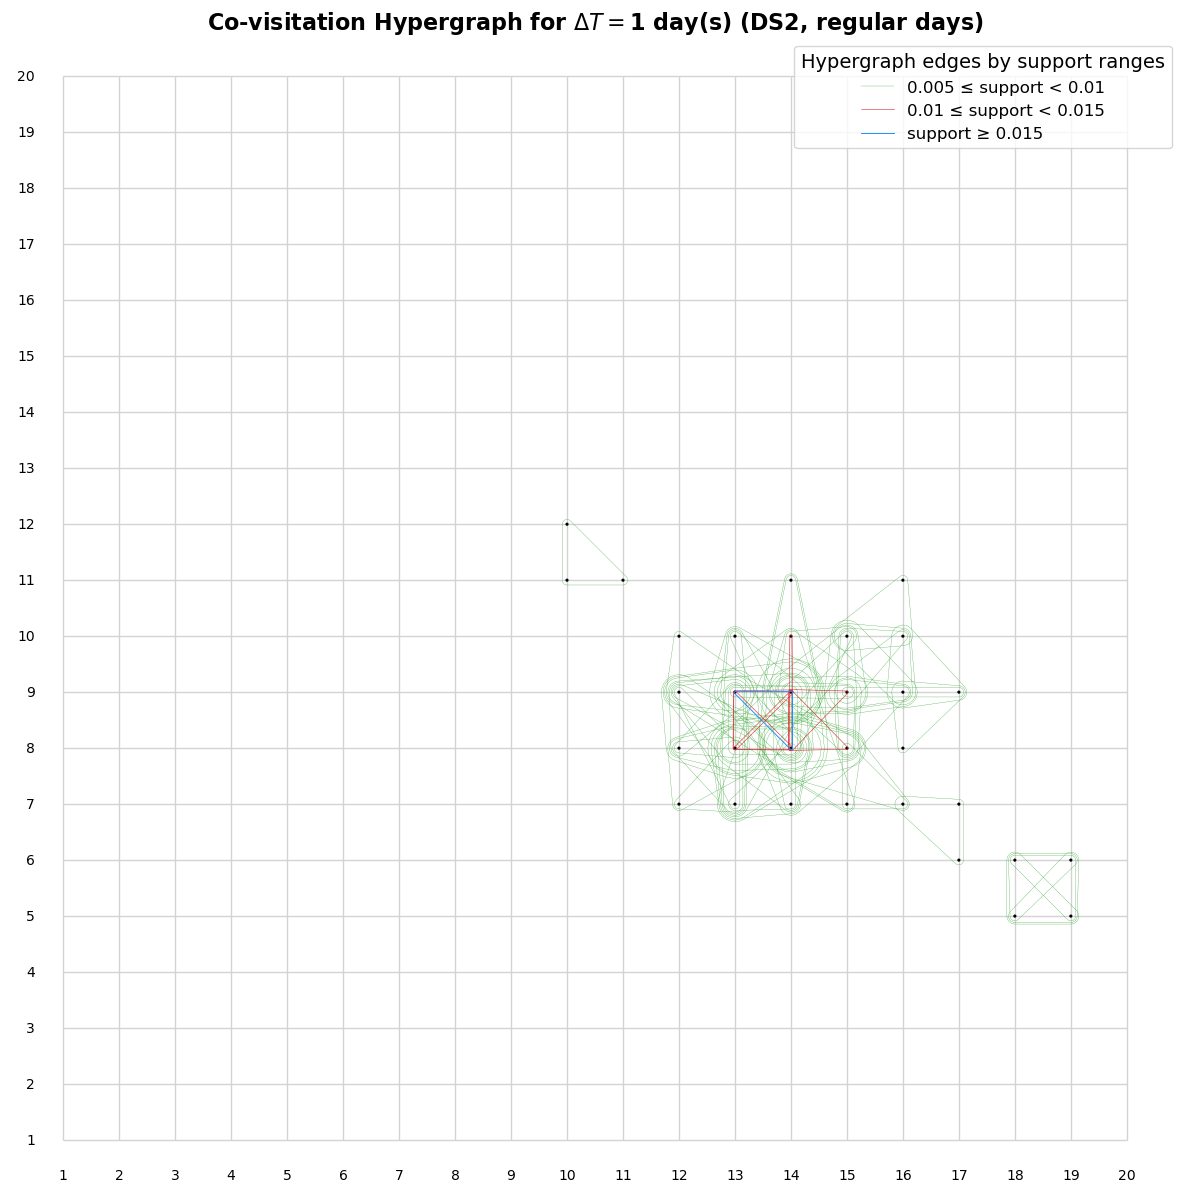

In [22]:
details = 'regular'
DeltaT = 1
exclusive_HG_reg_minsup = exclusive_HG_reg[DeltaT]
edge_widths = [0.2, 0.4, 0.7] 
init_radius = 0.2
rad_factor = 0.04
colors = ['tab:green', 'tab:red', 'dodgerblue']
alpha_values = [0.0001, 0.0005, 0.001] 
legend_text = ['0.005 ≤ support < 0.01', '0.01 ≤ support < 0.015', 'support ≥ 0.015']
plot_hypergraphs_with_colored_edges(exclusive_HG_reg_minsup,
            f'hypergraph_plot_minsup_all_{DeltaT}_ds2_type_{details}.png', edge_widths,
            init_radius, rad_factor, colors, alpha_values, legend_text, DeltaT, details, 3
)

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/p

(24, 36)
(4, 3)
(0, 0)
0 nodes


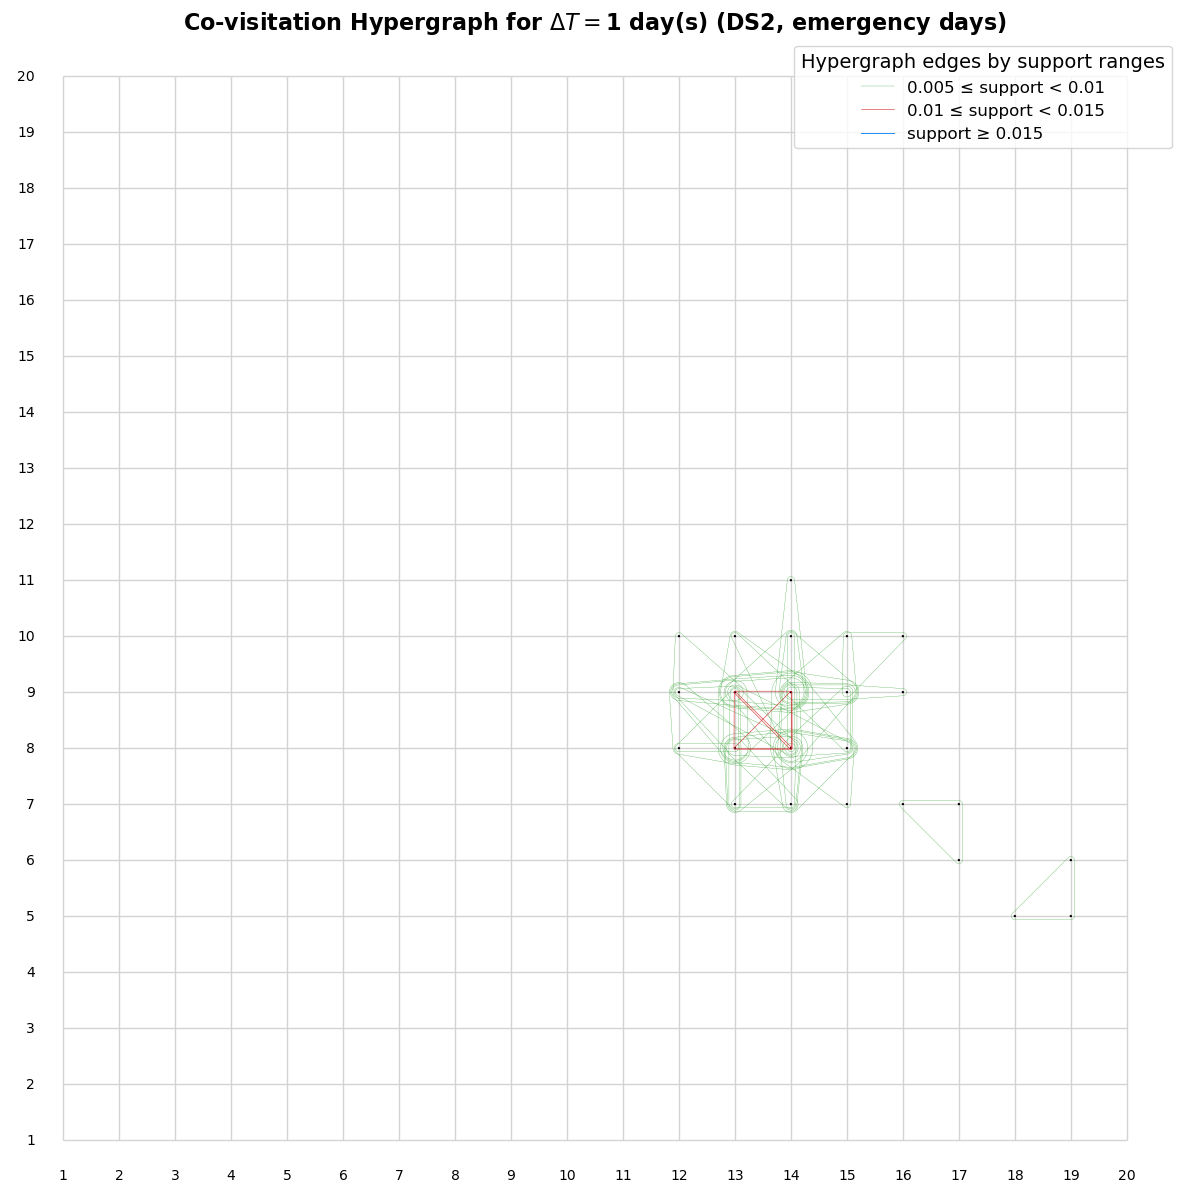

In [23]:
details = 'emergency'
DeltaT = 1
exclusive_HG_emg_minsup = exclusive_HG_emg[DeltaT]
edge_widths = [0.2, 0.4, 0.7] 
init_radius = 0.2
rad_factor = 0.04
colors = ['tab:green', 'tab:red', 'dodgerblue']
alpha_values = [0.0001, 0.0005, 0.001] 
legend_text = ['0.005 ≤ support < 0.01', '0.01 ≤ support < 0.015', 'support ≥ 0.015']
plot_hypergraphs_with_colored_edges(exclusive_HG_emg_minsup,
            f'hypergraph_plot_minsup_all_{DeltaT}_ds2_type_{details}.png', edge_widths,
            init_radius, rad_factor, colors, alpha_values, legend_text, DeltaT, details, 3
)

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be rem

(208, 3729)
(153, 758)
(27, 62)
(10, 11)


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:1494: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties = props.combine_first(self.properties)
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This

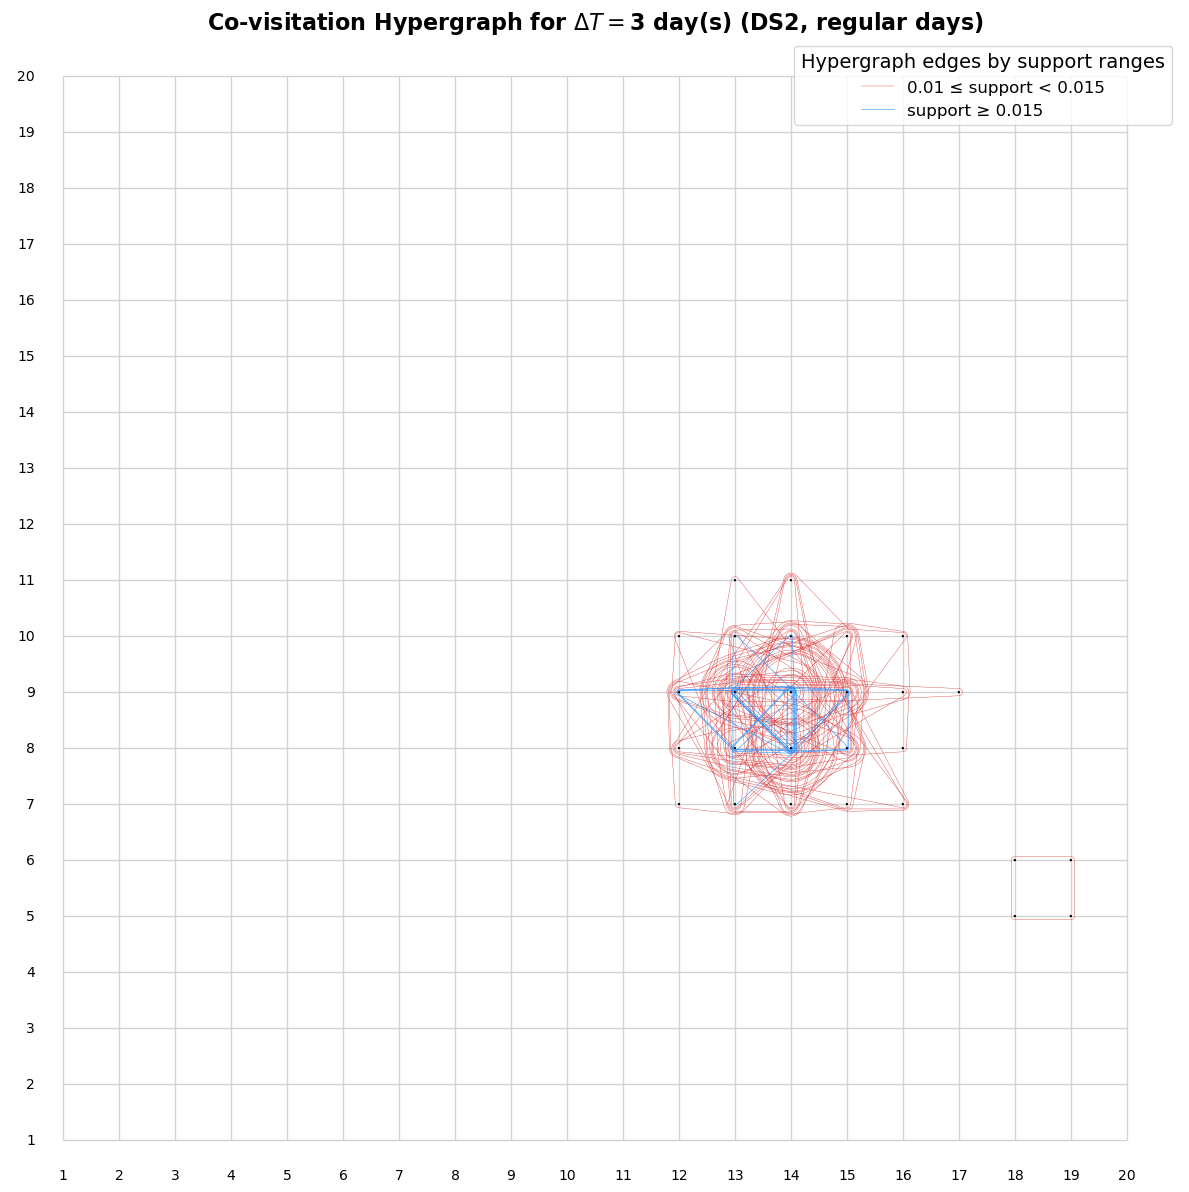

In [24]:
DeltaT = 3
details = "regular"
exclusive_HG_reg_minsup = exclusive_HG_reg[DeltaT]
print(exclusive_HG_reg_minsup[0].shape)
print(exclusive_HG_reg_minsup[1].shape)
edge_widths = [0.25, 0.4] 
init_radius = 0.2
rad_factor = 0.0075
colors = ['tab:red', 'dodgerblue']
alpha_values = [0.0005, 0.001] 
legend_text = ['0.01 ≤ support < 0.015', 'support ≥ 0.015']
plot_hypergraphs_with_colored_edges(exclusive_HG_reg_minsup[1:], 
                        f'hypergraph_plot_minsup_2and3_{DeltaT}_ds2_type_{details}.png',
                        edge_widths, init_radius, rad_factor, colors, alpha_values, 
                        legend_text, DeltaT, details, 4
)

/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be rem

(200, 2865)
(140, 577)
(20, 28)
(7, 4)


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/p

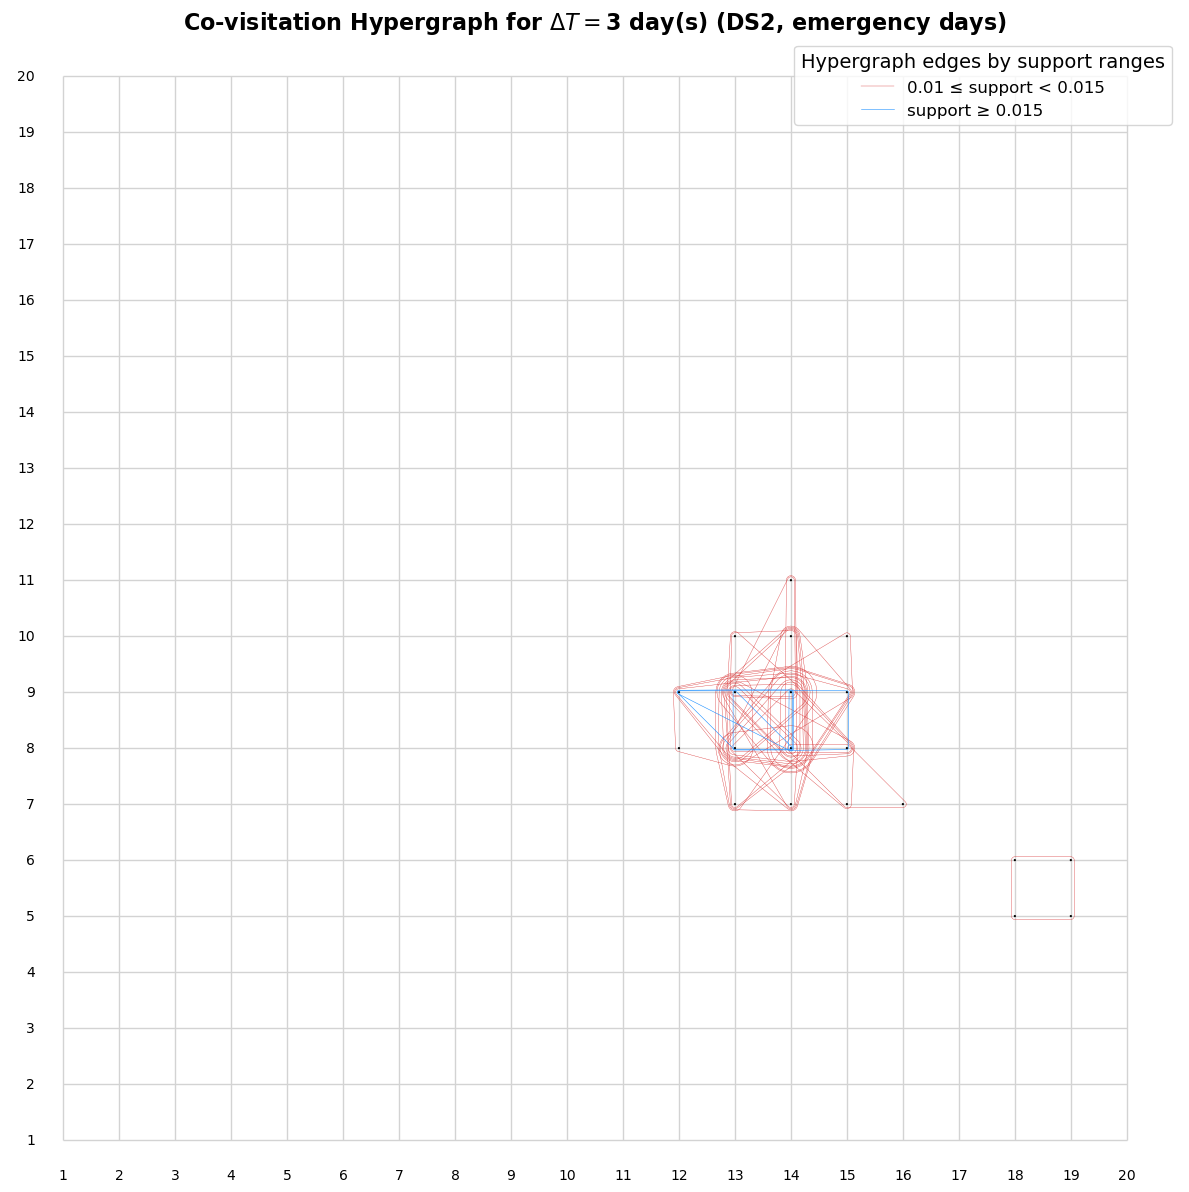

In [25]:
DeltaT = 3
details = "emergency"
exclusive_HG_emg_minsup = exclusive_HG_emg[DeltaT]
print(exclusive_HG_emg_minsup[0].shape)
print(exclusive_HG_emg_minsup[1].shape)
edge_widths = [0.25, 0.4] 
init_radius = 0.2
rad_factor = 0.0075
colors = ['tab:red', 'dodgerblue']
alpha_values = [0.0005, 0.001] 
legend_text = ['0.01 ≤ support < 0.015', 'support ≥ 0.015']
plot_hypergraphs_with_colored_edges(exclusive_HG_emg_minsup[1:], 
                        f'hypergraph_plot_minsup_2and3_{DeltaT}_ds2_type_{details}.png',
                        edge_widths, init_radius, rad_factor, colors, alpha_values, 
                        legend_text, DeltaT, details, 4
)

(238, 58711)
(200, 8540)
(55, 1423)


/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/user/miniconda3/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._dataframe.groupby(col1)[col2].unique().to_dict()
/Users/user/miniconda3/lib/p

(32, 264)


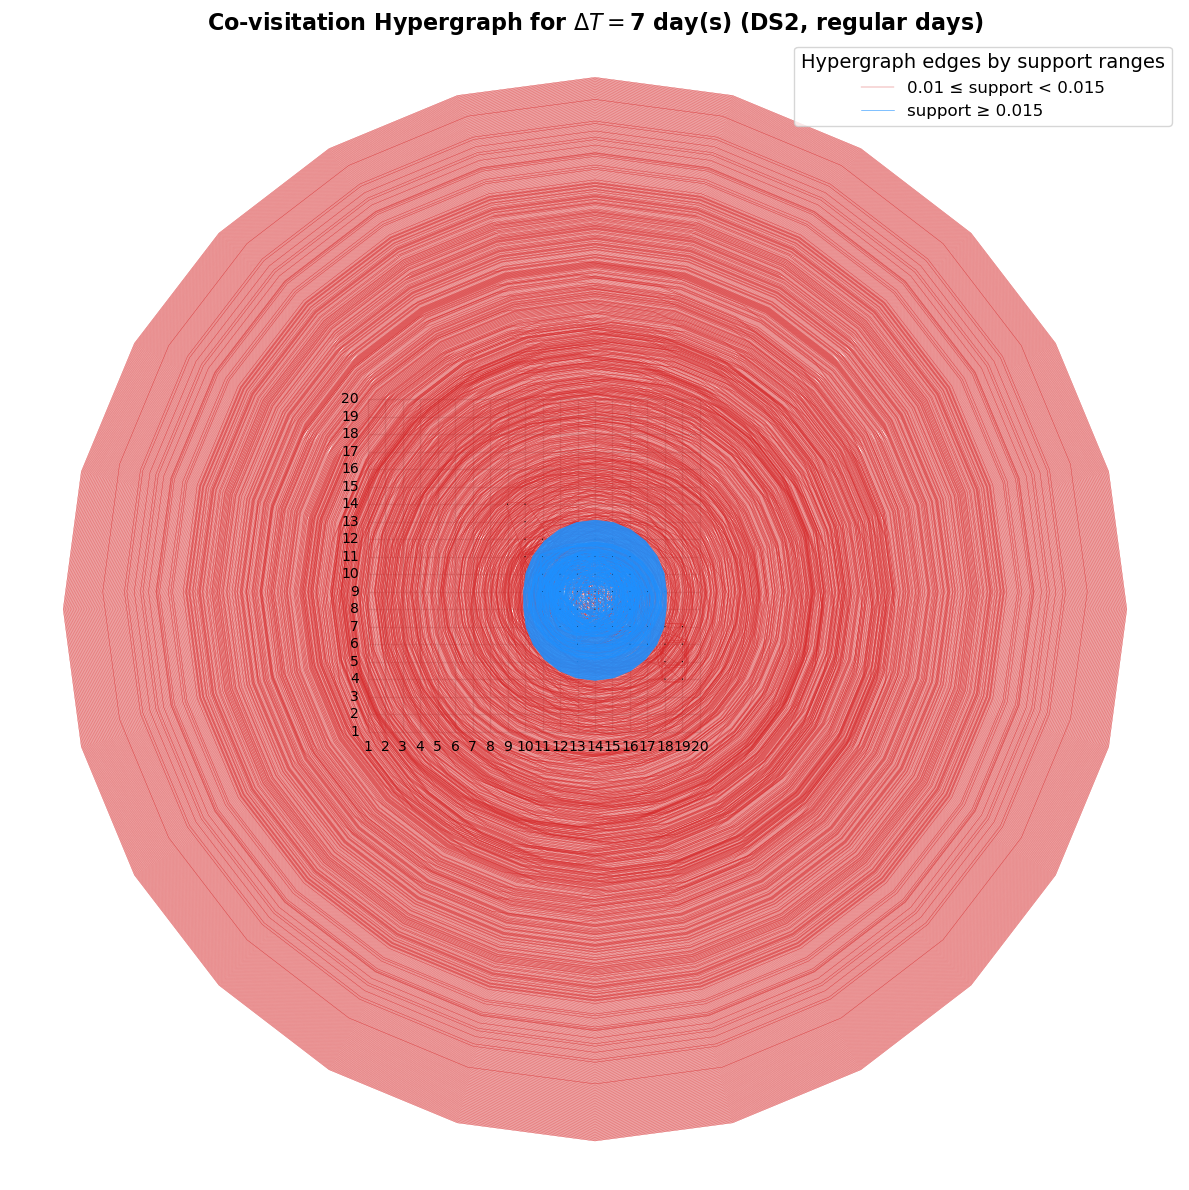

In [27]:
DeltaT = 7
details = "regular"
exclusive_HG_reg_minsup = exclusive_HG_reg[DeltaT]
print(exclusive_HG_reg_minsup[0].shape)
print(exclusive_HG_reg_minsup[1].shape)
edge_widths = [0.25, 0.4] 
init_radius = 0.2
rad_factor = 0.0075
colors = ['tab:red', 'dodgerblue']
alpha_values = [0.0005, 0.001] 
legend_text = ['0.01 ≤ support < 0.015', 'support ≥ 0.015']
plot_hypergraphs_with_colored_edges(exclusive_HG_reg_minsup[1:], 
                        f'hypergraph_plot_minsup_2and3_{DeltaT}_ds2_type_{details}.png',
                        edge_widths, init_radius, rad_factor, colors, alpha_values, 
                        legend_text, DeltaT, details, 5
)

# Step 5. Plot comparison of hypergraph structural properties 

In [28]:
def compute_degree_frequencies(hyperedges):
    degree_count = defaultdict(int)

    for edge in hyperedges:
        for node in edge:
            degree_count[node] += 1
    max_degree = max(degree_count.values())
    
    # Count the frequency of each degree
    degree_freq = defaultdict(int)
    for degree in degree_count.values():
        degree_freq[degree] += 1

    # Sort the degrees and their frequencies
    sorted_degrees = sorted(degree_freq.keys())
    sorted_frequencies = [degree_freq[degree] for degree in sorted_degrees]
    print(sorted_degrees)
    print(sorted_frequencies)
    return sorted_degrees, sorted_frequencies, degree_count

In [29]:
def compute_degrees_and_frequencies(HG_edges):
    degrees = {}
    frequencies = {}
    degree_counts = {}
    for DeltaT in HG_edges.keys():
        print(DeltaT)
        HG_edges_DeltaT = HG_edges[DeltaT]
        degrees[DeltaT] = []
        frequencies[DeltaT] = []
        degree_counts[DeltaT] = []
        for i in range(len(HG_edges[DeltaT])):
            print(f"Degree Distribution of hypergraph for DeltaT = {DeltaT} and min_sup = {min_sups[i]}")
            degs, freqs, deg_counts = compute_degree_frequencies(HG_edges_DeltaT[i])
            degrees[DeltaT].append(degs)
            frequencies[DeltaT].append(freqs)
            degree_counts[DeltaT].append(deg_counts)
    return degrees, frequencies, degree_counts

In [30]:
degrees_reg, frequencies_reg, degree_counts_reg = compute_degrees_and_frequencies(HG_reg_edges)

1
Degree Distribution of hypergraph for DeltaT = 1 and min_sup = 0.005
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 26, 31, 38, 39, 50, 56]
[34, 13, 12, 15, 6, 7, 7, 6, 6, 1, 3, 4, 1, 1, 3, 3, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1]
Degree Distribution of hypergraph for DeltaT = 1 and min_sup = 0.01
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 18]
[14, 11, 10, 7, 4, 3, 2, 1, 2, 1, 1, 2]
Degree Distribution of hypergraph for DeltaT = 1 and min_sup = 0.015
[1, 2, 3, 4, 5, 6, 9]
[17, 5, 1, 2, 1, 3, 2]
3
Degree Distribution of hypergraph for DeltaT = 3 and min_sup = 0.005
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 33, 34, 36, 37, 40, 41, 43, 44, 45, 46, 47, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 66, 69, 70, 73, 74, 76, 78, 83, 85, 86, 89, 90, 101, 103, 111, 112, 113, 121, 124, 132, 139, 140, 142, 144, 146, 150, 153, 158, 161, 199, 203, 205, 210, 213, 214, 237, 245, 254, 256, 264, 284, 306, 307, 317, 488, 498, 502,

In [31]:
degrees_emg, frequencies_emg, degree_counts_emg = compute_degrees_and_frequencies(HG_emg_edges)

1
Degree Distribution of hypergraph for DeltaT = 1 and min_sup = 0.005
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 22, 24, 26, 29, 33, 41, 42]
[27, 15, 11, 15, 3, 14, 5, 5, 4, 3, 4, 2, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1]
Degree Distribution of hypergraph for DeltaT = 1 and min_sup = 0.01
[1, 2, 3, 4, 5, 7, 9, 10, 13, 14]
[15, 13, 9, 4, 3, 4, 1, 2, 1, 1]
Degree Distribution of hypergraph for DeltaT = 1 and min_sup = 0.015
[1, 2, 4, 5, 6, 7]
[11, 4, 1, 2, 2, 1]
3
Degree Distribution of hypergraph for DeltaT = 3 and min_sup = 0.005
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 40, 41, 42, 44, 45, 51, 53, 54, 55, 60, 61, 63, 64, 67, 69, 71, 73, 79, 87, 89, 91, 93, 97, 100, 102, 110, 112, 113, 114, 120, 123, 139, 144, 145, 159, 163, 165, 187, 188, 189, 190, 197, 202, 215, 235, 256, 348, 349, 369, 394, 438, 526, 577]
[13, 11, 14, 6, 10, 4, 5, 4, 7, 5, 3, 2, 3, 1, 6, 3, 7, 3, 1, 2, 1, 1, 3, 1, 2, 1, 2, 2, 

In [32]:
def calculate_ccdf(degrees, frequencies):
    """
    Calculate the CCDF for each degree distribution.
    
    Parameters:
    degrees (list): List of degrees in the network.
    frequencies (list): Frequency of each degree.
    
    Returns:
    sorted_degrees (list): Sorted degrees.
    ccdf (list): CCDF values corresponding to the sorted degrees.
    """
    sorted_degrees = np.array(sorted(degrees))
    sorted_frequencies = np.array([frequencies[degrees.index(d)] for d in sorted_degrees])
    
    # Calculate cumulative counts from the largest degree downwards
    cumulative_counts = np.cumsum(sorted_frequencies[::-1])[::-1]
    ccdf = cumulative_counts / cumulative_counts[0]  # Normalize to get CCDF
    
    return sorted_degrees, ccdf

def plot_degree_distribution_ccdf(degrees, frequencies, min_sup_value, plot_path):
    """
    Plots CCDF of degree distributions on a log-log scale for the first min_sup value for each Delta T.

    Parameters:
    degrees (dict): Dictionary where each key is a ΔT value, and each value is a list of lists of degrees for each min_sup.
    frequencies (dict): Dictionary where each key is a ΔT value, and each value is a list of lists of frequencies of degrees for each min_sup.
    min_sup_value (float): The minimum support value used for the first element in each list.
    plot_path (str): Path to save the plot image.
    """
    # Define markers for visual distinction, and set all curves to black
    markers = ['o', 's', '^', 'D', 'v', 'p', '*']
    colors = ['tab:green', 'tab:blue', 'tab:red']
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Track index for marker selection
    marker_idx = 0

    # Loop over each ΔT value and plot only the first min_sup level
    i = 0
    for delta_t in degrees.keys():
        if delta_t not in frequencies:
            print(f"Warning: ΔT={delta_t} is missing in frequencies")
            continue
        
        # Take only the first min_sup value for the plot
        degree_list = degrees[delta_t][0]
        frequency_list = frequencies[delta_t][0]

        # Calculate CCDF
        sorted_degrees, ccdf = calculate_ccdf(degree_list, frequency_list)
        
        # Choose marker, cycling if we run out of distinct options
        marker = markers[marker_idx % len(markers)]
        label = f"ΔT={delta_t}"
        
        # Plot the CCDF curve in black with the specified marker
        ax.plot(
            sorted_degrees, ccdf,
            color=colors[i], linewidth=1.5, linestyle='-', marker=marker, markersize=2,
            label=label
        )
        
        # Increment marker index
        marker_idx += 1
        i += 1
    # Set logarithmic scales for both axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Set labels and title
    ax.set_xlabel('Degree (Number of hyperedges incident on a node)', fontsize=12)
    ax.set_ylabel(r'P(Degree ≥ k)', fontsize=12)  # Updated y-axis label with probability notation
    ax.set_title(f'CCDF of Degree Distribution for Various ΔT Values (min_sup={min_sup_value})', fontsize=14)
    
    # Configure legend and display plot
    ax.legend(title="ΔT values", loc="upper right", fontsize=10)
    plt.tight_layout()
    plt.savefig(plot_path, dpi=600)
    plt.show()

# Example usage:
# plot_degree_distribution_ccdf(degrees, frequencies, min_sup_value=0.005, plot_path='degree_distribution_ccdf.png')


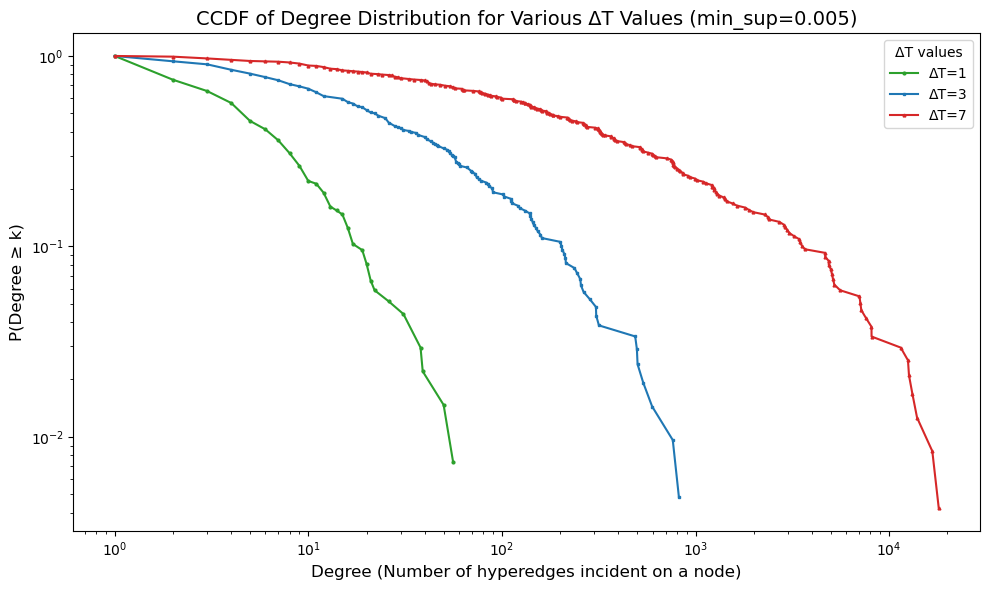

In [33]:
details = "regular"
plot_path = f'degree_distribution_comparison_minsup_0.005_ds2_type_{details}.png'
plot_degree_distribution_ccdf(degrees_reg, frequencies_reg, 0.005, plot_path)

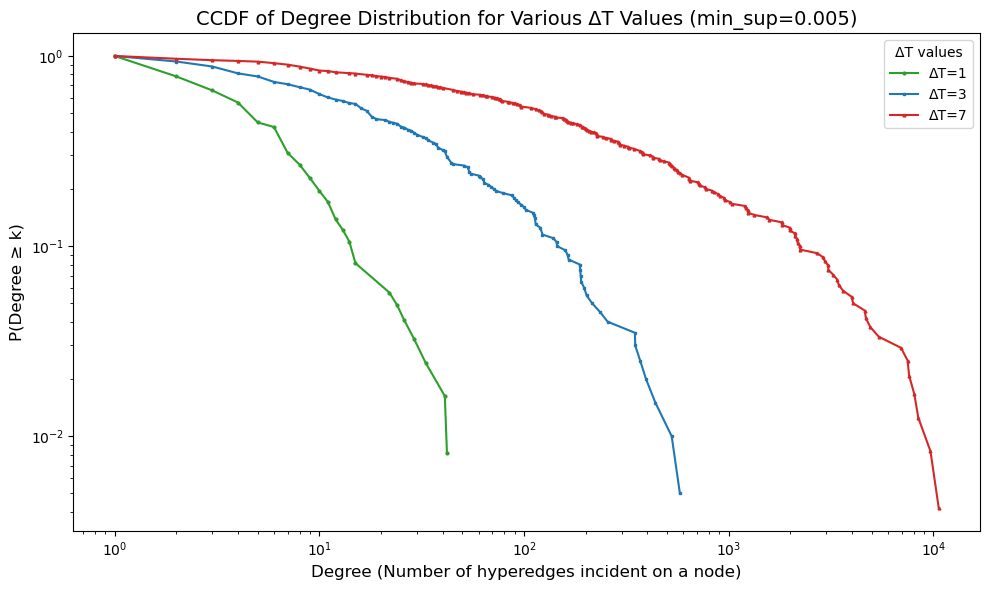

In [34]:
details = "emergency"
plot_path = f'degree_distribution_comparison_minsup_0.005_ds2_type_{details}.png'
plot_degree_distribution_ccdf(degrees_emg, frequencies_emg, 0.005, plot_path)

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def plot_hyperedge_size_distribution(hg_edges, plot_path):
    """
    Plots the hyperedge size distribution for min_sup = 0.005 for each ΔT value.
    Annotates each bar with the exact count on top of the bars.

    Parameters:
    hg_edges (dict): Dictionary with ΔT values as keys and a list of lists of hyperedges for each min_sup.
    plot_path (str): Path to save the plot image.
    """
    # Define the color for each ΔT value
    colors = ['seagreen', 'tab:red', 'dodgerblue']
    legend_text = ['ΔT = 1', 'ΔT = 3', 'ΔT = 7']

    # Collect all unique hyperedge sizes across all ΔT values for min_sup = 0.005
    all_sizes = set()
    size_freqs = []

    # Loop through the ΔT values and take the first min_sup (index 0)
    for delta_t in hg_edges:
        # Only consider the first min_sup value (index 0)
        hyperedges = hg_edges[delta_t][0]
        hyperedge_size = [len(edge) for edge in hyperedges]  # Get the size of each hyperedge
        size_freq = {}

        for size in hyperedge_size:
            if size not in size_freq:
                size_freq[size] = 0
            size_freq[size] += 1

        size_freqs.append(size_freq)
        all_sizes.update(size_freq.keys())  # Add the sizes to the set of all sizes

    # Sort all sizes for consistent plotting order
    all_sizes = sorted(all_sizes)

    # Prepare data for the bar plot
    bar_width = 0.2  # Width of each bar
    x = np.arange(len(all_sizes))  # x-axis positions for each hyperedge size
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each ΔT value's data for min_sup = 0.005
    for i, (size_freq, label, color) in enumerate(zip(size_freqs, legend_text, colors)):
        # Get frequencies for each size, using 0 for sizes not in the current hypergraph
        frequencies = [size_freq.get(size, 0) for size in all_sizes]

        # Skip sizes with zero frequency for log scale plot
        frequencies = [f for f in frequencies if f > 0]
        valid_sizes = [size for size, freq in zip(all_sizes, frequencies) if freq > 0]

        # Skip plotting if all frequencies are zero
        if len(frequencies) == 0:
            continue

        # Create bars for the valid sizes
        bars = ax.bar(x[:len(frequencies)] + i * bar_width - (len(hg_edges) - 1) * bar_width / 2, 
                      frequencies, width=bar_width, label=label, color=color)

        # Annotate each bar with the exact frequency value on top of the bar
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only add annotations for bars with non-zero height
                ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, str(int(height)),
                        ha='center', va='bottom', fontsize=7)

    # Set logarithmic scale for y-axis
    ax.set_yscale('log')

    # Customize the plot
    ax.set_xticks(x[:len(frequencies)])  # Adjust x-ticks to only show valid sizes
    ax.set_xticklabels(valid_sizes)  # Update x-tick labels to match valid sizes
    ax.set_xlabel('Hyperedge Size (Number of nodes)', fontsize=12)
    ax.set_ylabel('Frequency (Log-scale)', fontsize=12)
    ax.set_title('Hyperedge Size Distribution for min_sup = 0.005 across Different ΔT Values', fontsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer labels on x-axis

    # Add legend
    ax.legend(title='ΔT values', loc='upper right', fontsize=10)

    # Save and show plot
    plt.tight_layout()
    plt.savefig(plot_path, dpi=600)
    plt.show()

# Example usage:
# Assuming `hg_edges` is your dictionary with ΔT values as keys and lists of hyperedges for each min_sup
# hg_edges = {1: [[edge1, edge2, edge3], ...], 3: [[edge4, edge5], ...], 7: [[edge6, edge7, edge8], ...]}
# plot_hyperedge_size_distribution(hg_edges, plot_path='hyperedge_size_distribution_min_sup_0_005.png')


In [84]:
def plot_hyperedge_size_distribution_curves(hg_reg_edges, hg_emg_edges, plot_path):
    """
    Plots the hyperedge size distribution as curves for min_sup = 0.005 for each ΔT value,
    comparing regular days and emergency days.

    Parameters:
    hg_reg_edges (dict): Dictionary with ΔT values as keys and a list of lists of hyperedges for regular days.
    hg_emg_edges (dict): Dictionary with ΔT values as keys and a list of lists of hyperedges for emergency days.
    plot_path (str): Path to save the plot image.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.ticker import MaxNLocator

    # Define colors and markers for regular and emergency data
    reg_color = 'tab:blue'
    emg_color = 'tab:red'
    markers = ['o', 's', '^']  # Markers for ΔT = 1, 3, 7
    legend_text_reg = ['ΔT = 1 (Regular)', 'ΔT = 3 (Regular)', 'ΔT = 7 (Regular)']
    legend_text_emg = ['ΔT = 1 (Emergency)', 'ΔT = 3 (Emergency)', 'ΔT = 7 (Emergency)']

    # Collect all unique hyperedge sizes across both types for min_sup = 0.005
    all_sizes = set()
    reg_size_freqs = []
    emg_size_freqs = []

    # Process regular hypergraphs
    for delta_t in hg_reg_edges:
        hyperedges = hg_reg_edges[delta_t][0]
        hyperedge_size = [len(edge) for edge in hyperedges]
        size_freq = {}

        for size in hyperedge_size:
            size_freq[size] = size_freq.get(size, 0) + 1

        reg_size_freqs.append(size_freq)
        all_sizes.update(size_freq.keys())

    # Process emergency hypergraphs
    for delta_t in hg_emg_edges:
        hyperedges = hg_emg_edges[delta_t][0]
        hyperedge_size = [len(edge) for edge in hyperedges]
        size_freq = {}

        for size in hyperedge_size:
            size_freq[size] = size_freq.get(size, 0) + 1

        emg_size_freqs.append(size_freq)
        all_sizes.update(size_freq.keys())

    # Sort all sizes for consistent plotting order
    all_sizes = sorted(all_sizes)

    # Prepare data for the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot regular data as solid curves in blue
    for i, (size_freq, label, marker) in enumerate(zip(reg_size_freqs, legend_text_reg, markers)):
        # Filter valid (size, frequency) pairs where frequency > 0
        valid_sizes = [size for size, freq in size_freq.items() if freq > 0]
        valid_frequencies = [freq for size, freq in size_freq.items() if freq > 0]
        ax.plot(
            valid_sizes, valid_frequencies, label=label, color=reg_color,
            marker=marker, linestyle='-', linewidth=2
        )

    # Plot emergency data as solid curves in red
    for i, (size_freq, label, marker) in enumerate(zip(emg_size_freqs, legend_text_emg, markers)):
        # Filter valid (size, frequency) pairs where frequency > 0
        valid_sizes = [size for size, freq in size_freq.items() if freq > 0]
        valid_frequencies = [freq for size, freq in size_freq.items() if freq > 0]
        ax.plot(
            valid_sizes, valid_frequencies, label=label, color=emg_color,
            marker=marker, linestyle='-', linewidth=2
        )

    # Set logarithmic scale for y-axis
    ax.set_yscale('log')

    # Customize the plot
    ax.set_xticks(all_sizes)
    ax.set_xticklabels(all_sizes)
    ax.set_xlabel('Hyperedge Size (Number of nodes)', fontsize=12)
    ax.set_ylabel('Frequency (Log Scale)', fontsize=12)
    ax.set_title('Comparison of Hyperedge Size Distributions for Regular and Emergency Days (min_sup = 0.005)', fontsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer labels on x-axis

    # Add legend
    ax.legend(title='ΔT values and Type', loc='upper right', fontsize=10)

    # Save and show the plot
    plt.tight_layout()
    plt.savefig(plot_path, dpi=600)
    plt.show()


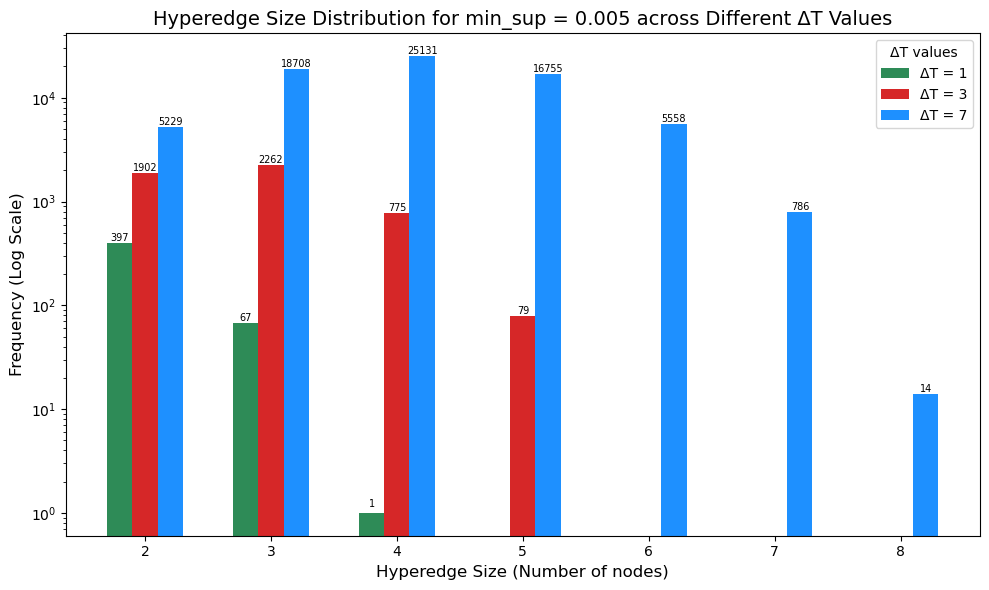

In [85]:
details = "regular"
plot_path = f'hyperedge_size_distribution_minsup_0.005_ds2_type_{details}.png'
plot_hyperedge_size_distribution(HG_reg_edges, plot_path)

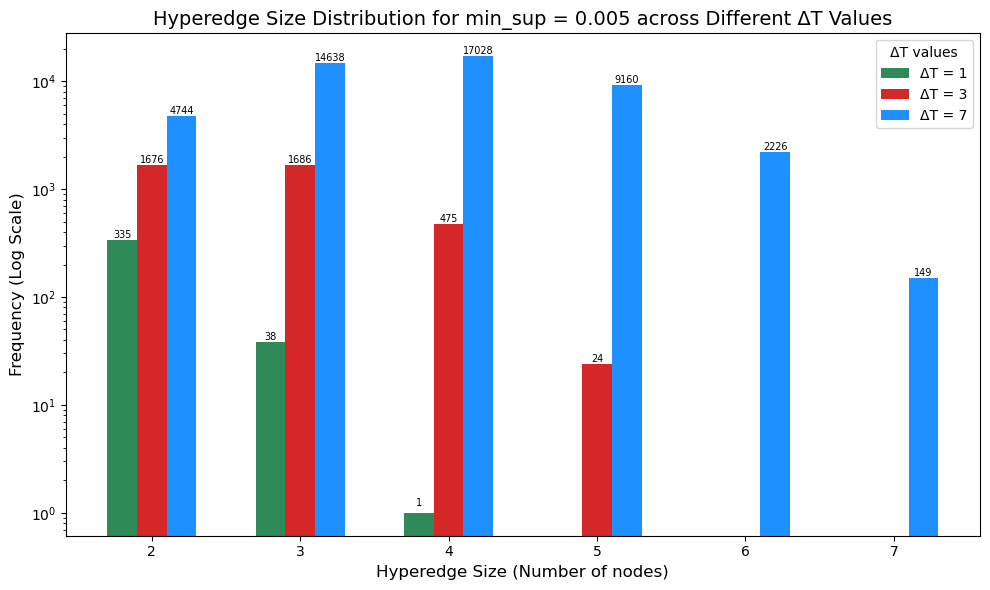

In [86]:
details = "emergency"
plot_path = f'hyperedge_size_distribution_minsup_0.005_ds2_type_{details}.png'
plot_hyperedge_size_distribution(HG_emg_edges, plot_path)

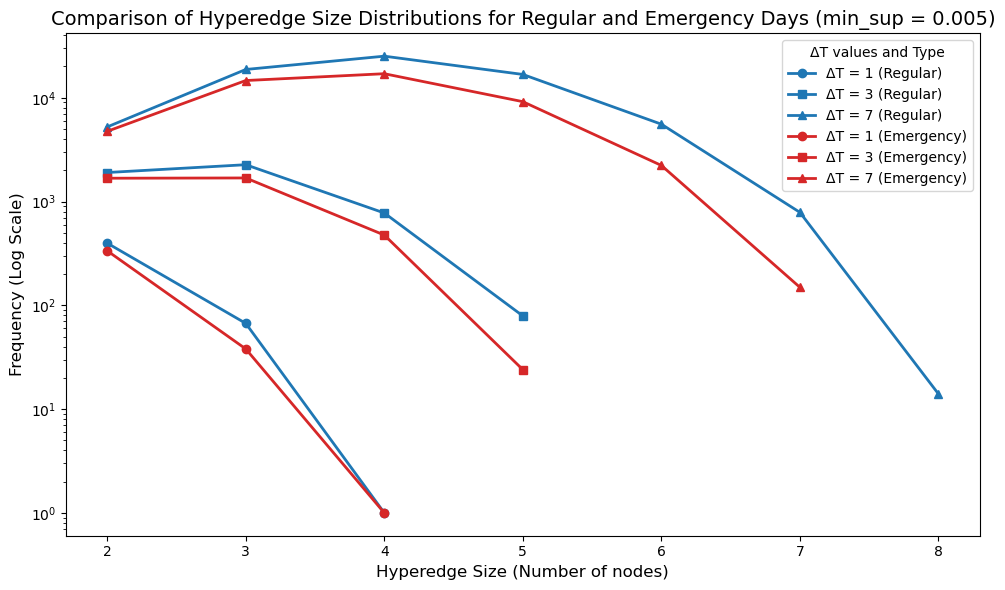

In [87]:
plot_path = f'hyperedge_size_distribution_minsup_0.005_ds2_reg_vs_emg.png'
plot_hyperedge_size_distribution_curves(HG_reg_edges, HG_emg_edges, plot_path)

In [ ]:
def plot_heat_map_of_node_degree(degree_count, delta_t, ms_ind, plot_path, bins, colors):
    """
    Plots a heatmap of node degrees for a single hypergraph with a specified ΔT value,
    using discrete color bins, bounding boxes around cells, and small spaces between cells.
    
    Parameters:
    degree_count (dict): Dictionary representing degree counts of nodes for a single hypergraph.
                         Keys are (x, y) coordinates, values are degree counts.
    delta_t (int): The ΔT value to label the plot.
    plot_path (str): Path to save the plot image.
    """
    # Initialize a 20x20 grid for the heatmap
    degree_grid = np.zeros((20, 20))
    
    # Normalize the bins using BoundaryNorm
    norm = BoundaryNorm(bins, ncolors=len(colors))  # Normalize based on the bins

    # Populate the degree grid based on (x, y) coordinates
    for (x, y), degree in degree_count.items():
        # Assuming (x, y) are within the range [1, 20]
        if 1 <= x <= 20 and 1 <= y <= 20:
            degree_grid[y-1, x-1] = degree  # Fill in the grid (0-indexed)

    # Create the heatmap with discrete color bins and a bounding box around cells
    plt.figure(figsize=(8, 8))
    sns.heatmap(
        degree_grid, fmt='.0f', cmap=colors, norm=norm, cbar=True,
        xticklabels=np.arange(1, 21), yticklabels=np.arange(1, 21),
        cbar_kws={'ticks': bins, 'label': 'Degree Count', 'shrink': 0.6},  # Shrink the color bar
        linewidths=0.5,  # Small line width for spacing between cells
        linecolor='lightgrey',  # Color of the lines around each cell
        square=True  # Ensure that cells are square-shaped
    )

    # Set titles and labels
    plt.title(f'(ΔT = {delta_t}, min_sup = {min_sups[ms_ind]})', fontsize=14)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.gca().invert_yaxis()  # Invert y-axis for correct orientation

    # Save and display the plot
    plt.tight_layout()
    plt.savefig(plot_path, dpi=600)
    plt.show()


In [125]:
def generate_adaptive_log_bins(max_deg):
    """
    Generates a list of bin edges for degree counts with the first bin at 0, the second at 1,
    and the remaining bins increasing gradually up to max_deg, using a logarithmic scale.
    
    Parameters:
    max_deg (int): The maximum degree to set as the upper bound for the last bin.
    
    Returns:
    list: A list of bin edges.
    """
    # Determine the total bins as a function of max_deg (using log scale)
    total_bins = int(np.ceil(np.log2(max_deg))) + 2  # +2 to include bins for 0 and 1

    # Start with bins 0 and 1 as the first two bins
    bins = [0, 1]
    
    # Remaining bins to generate
    remaining_bins = total_bins - 2

    # Use a power-based scale to create the remaining bins between 1 and max_deg
    power_base = np.linspace(0, 1, remaining_bins) ** 1.5  # Smooth scaling
    scale_bins = (1 + (max_deg - 1) * power_base).astype(int)  # Shift up to start at 1, end at max_deg

    # Convert scale_bins to integers, rounding and removing duplicates
    bins.extend(np.round(scale_bins).astype(int))
    bins[-1] = max_deg  # Ensure the last bin equals max_deg
    
    # Remove duplicates from rounding
    bins = sorted(set(bins))
    
    return bins

In [126]:
def generate_adaptive_colors(num_bins):
    """
    Generates a list of colors from white to black for the number of bins.
    
    Parameters:
    num_bins (int): The number of colors (bins) to generate.
    
    Returns:
    list: A list of grayscale colors for each bin.
    """
    # Use a 'Greys' color map from matplotlib to generate shades from white to black
    cmap = plt.cm.Reds  # This will generate shades of gray from white to black
    colors = [cmap(i / (num_bins - 1)) for i in range(num_bins)]  # Generate the color scale
    return colors

In [127]:
def plot_degree_heat_map(deltaT, ms_ind, details, degree_counts):
    degree_count_deltaT = degree_counts[deltaT]
    deg_counts = degree_count_deltaT[ms_ind]
    max_deg = 0
    max_deg_node = (-1, -1)
    plot_path = f'heat_map_node_degree_deltaT_{deltaT}_minsup_{min_sups[ms_ind]}_ds2_type_{details}.png'
    for node in deg_counts:
        if deg_counts[node] > max_deg:
            max_deg = deg_counts[node]
            max_deg_node = node
    print(max_deg_node, max_deg)
    bins = generate_adaptive_log_bins(max_deg)
    colors = generate_adaptive_colors(len(bins))
    print(bins)
    print(colors)
    plot_heat_map_of_node_degree(deg_counts, deltaT, ms_ind, plot_path, bins, colors)

In [128]:
deltaT = 1
ms_ind = 0
details = "regular"
plot_degree_heat_map(deltaT, ms_ind, details, degree_counts_reg)

(14, 8) 56
[0, 1, 5, 14, 26, 40, 56]
[(1.0, 0.9607843137254902, 0.9411764705882353, 1.0), (0.9935870818915802, 0.8323414071510957, 0.7624913494809689, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.6943944636678201, 0.07003460207612457, 0.09231833910034601, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


NameError: name 'plot_heat_map_of_node_degree' is not defined

In [129]:
deltaT = 1
ms_ind = 0
details = "emergency"
plot_degree_heat_map(deltaT, ms_ind, details, degree_counts_emg)

(14, 8) 42
[0, 1, 4, 11, 20, 30, 42]
[(1.0, 0.9607843137254902, 0.9411764705882353, 1.0), (0.9935870818915802, 0.8323414071510957, 0.7624913494809689, 1.0), (0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.8901960784313725, 0.18562091503267975, 0.15294117647058825, 1.0), (0.6943944636678201, 0.07003460207612457, 0.09231833910034601, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


NameError: name 'plot_heat_map_of_node_degree' is not defined

In [130]:
deltaT = 3
ms_ind = 0
details = "regular"
plot_degree_heat_map(deltaT, ms_ind, details, degree_counts_reg)

(14, 8) 821
[0, 1, 31, 86, 158, 243, 340, 447, 563, 688, 821]
[(1.0, 0.9607843137254902, 0.9411764705882353, 1.0), (0.9969242599000384, 0.8961937716262975, 0.8489042675893886, 1.0), (0.9913725490196079, 0.7913725490196079, 0.7082352941176471, 1.0), (0.9882352941176471, 0.6715417147251057, 0.5605382545174933, 1.0), (0.9874509803921568, 0.5411764705882353, 0.41568627450980394, 1.0), (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0), (0.9466666666666667, 0.26823529411764707, 0.19607843137254902, 1.0), (0.8503344867358708, 0.14686658977316416, 0.13633217993079583, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.5946174548250673, 0.04613610149942329, 0.07558631295655516, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]


NameError: name 'plot_heat_map_of_node_degree' is not defined

In [ ]:
deltaT = 3
ms_ind = 0
details = "emergency"
plot_degree_heat_map(deltaT, ms_ind, details, degree_counts_emg)

In [ ]:
deltaT = 7
ms_ind = 0
details = "regular"
plot_degree_heat_map(deltaT, ms_ind, details, degree_counts_reg)

In [ ]:
deltaT = 7
ms_ind = 0
details = "emergency"
plot_degree_heat_map(deltaT, ms_ind, details, degree_counts_emg)

In [425]:
from collections import defaultdict

def get_id(node, grid_size):
    """Compute the ID for a node (x, y) based on grid_size."""
    x, y = node
    return grid_size * (x - 1) + y

def compute_co_degree(hyperedges, grid_size):
    """
    Computes the co-degree for pairs of nodes from hyperedges, ensuring consistent ordering
    of node pairs using their IDs.

    Parameters:
    hyperedges (list): List of hyperedges, where each hyperedge is a set of (x, y) coordinates.
    grid_size (int): Number of columns in the grid, used to compute node IDs for sorting.

    Returns:
    dict: Dictionary with keys as pairs of node coordinates ((x1, y1), (x2, y2))
          and values as their co-degree (number of shared hyperedges).
    """
    co_degree = defaultdict(int)
    
    # Calculate co-degree for each pair of nodes in the hyperedges
    for edge in hyperedges:
        edge = list(edge)  # Convert set to list
        for i in range(len(edge)):
            for j in range(i + 1, len(edge)):
                # Compute IDs for both nodes
                id1 = get_id(edge[i], grid_size)
                id2 = get_id(edge[j], grid_size)
                # Sort the pair based on their IDs for consistent ordering
                if id1 < id2:
                    pair = (edge[i], edge[j])
                else:
                    pair = (edge[j], edge[i])
                # Increment co-degree for the pair
                co_degree[pair] += 1

    return co_degree


In [426]:
#Repairing here
def get_hyperedges(deltaT, ms_ind, details, min_size):
    if details == "regular":
        hyperedges = HG_reg_edges[deltaT][ms_ind]
    else:
        hyperedges = HG_emg_edges[deltaT][ms_ind]
    filtered_hyperedges = [edge for edge in hyperedges if len(edge) >= min_size]
    print(f'({details}, {deltaT}, {ms_ind}): {len(filtered_hyperedges)}/{len(hyperedges)}')
    return filtered_hyperedges

In [456]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_single_co_degree_graph(co_degree, grid_size, threshold, deltaT, ms_ind, details, title="Co-Degree Graph"):
    """
    Creates and plots a single co-degree graph on a grid with edges, 
    where edge widths are proportional to the co-degree weights.
    
    Parameters:
    co_degree (dict): Co-degree dictionary with keys as node pairs and values as weights.
    grid_size (int): Size of the spatial grid (e.g., 20 for a 20x20 grid).
    threshold (int): Minimum co-degree value to include an edge in the graph.
    deltaT (int): Temporal window value (for labeling).
    ms_ind (int): Index for the min_sup value.
    title (str): Title of the plot.
    """
    # Create a graph
    G = nx.Graph()

    # Add edges with co-degree weights above the threshold
    for (node1, node2), weight in co_degree.items():
        if weight >= threshold:
            G.add_edge(node1, node2, weight=weight)

    # Collect all weights to find the maximum for normalization
    all_weights = [data['weight'] for _, _, data in G.edges(data=True)]
    max_val = max(all_weights) if all_weights else 1  # Avoid division by zero
    print(f"max co_degree: {max_val}")

    # Position nodes directly using their grid coordinates (x, y)
    pos = {node: (node[0], node[1]) for node in G.nodes()}

    # Plot the graph
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Define the grid size range
    grid_min, grid_max = 1, grid_size
    grid_color = 'lightgray'

    # Set axis limits and grid
    ax.set_xlim(grid_min - 0.5, grid_max + 0.5)
    ax.set_ylim(grid_min - 0.5, grid_max + 0.5)
    ax.vlines(range(grid_min, grid_max + 1), grid_min, grid_max, color=grid_color, linestyle='-', linewidth=1, zorder=0)
    ax.hlines(range(grid_min, grid_max + 1), grid_min, grid_max, color=grid_color, linestyle='-', linewidth=1, zorder=0)

    # Add tick marks on the axes
    ax.set_xticks(range(grid_min, grid_max + 1))
    ax.set_yticks(range(grid_min, grid_max + 1))
    ax.set_xticklabels(range(grid_min, grid_max + 1), fontsize=10)
    ax.set_yticklabels(range(grid_min, grid_max + 1), fontsize=10)
    ax.tick_params(axis='both', which='both', direction='in', length=5, width=0.5, colors='black')

    # Adjust axis labels' distance from tick labels
    ax.set_xlabel('X Coordinate', fontsize=12, labelpad=20)
    ax.set_ylabel('Y Coordinate', fontsize=12, labelpad=20)
        
    if details == "regular":
        col = 'tab:blue'
    else:
        col = 'tab:red'


    # Plot edges with width proportional to the co-degree weight
    for node1, node2, data in G.edges(data=True):
        weight = data['weight']
        x1, y1 = pos[node1]
        x2, y2 = pos[node2]
        # Scale the width by a factor of the weight
        width = weight / max_val * 5  # Scale width by co-degree weight
         # Plot edge as a line
        ax.add_line(Line2D([x1, x2], [y1, y2], color=col, linewidth=width, alpha=1))

    # Plot nodes
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='black', ax=ax)

    # Add grid lines and ensure tick labels are visible
    ticks = range(1, grid_size + 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(range(1, grid_size + 1), fontsize=10)
    ax.set_yticklabels(range(1, grid_size + 1), fontsize=10)
    ax.grid(which="both", color="lightgrey", linestyle="--", linewidth=0.5)

    # Ensure the spines are visible
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)  # Set the line width for better visibility

    # Customize the plot title
    ax.set_title(f'{title} (ΔT = {deltaT}, min_sup = {ms_ind}) ({details})', fontsize=14)

    plt.grid(True)
    # Ensure the layout fits well
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'co_degree_graph_deltaT_{deltaT}_ms_{ms_ind}.png', dpi=600)

    # Show the plot
    plt.show()


In [554]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

    
def plot_unique_edges_in_co_degree_graphs(co_degree_reg, co_degree_emg, grid_size, threshold, deltaT, ms_ind):
    """
    Creates and plots two co-degree graphs (regular and emergency) on the same grid with curved edges,
    where edges are color-coded to show only edges that are unique to either regular or emergency graphs.
    
    Parameters:
    co_degree_reg (dict): Co-degree dictionary for the regular graph (G_reg).
    co_degree_emg (dict): Co-degree dictionary for the emergency graph (G_emg).
    grid_size (int): Size of the spatial grid (e.g., 20 for a 20x20 grid).
    threshold (int): Minimum co-degree value to include an edge in the graph.
    deltaT (int): Temporal window value (for labeling).
    ms_ind (int): Index for the min_sup value.
    """

    # Create two graphs: one for regular (G_reg) and one for emergency (G_emg)
    G_reg = nx.Graph()
    G_emg = nx.Graph()

    # Add edges for regular graph with co-degree above the threshold
    for (node1, node2), weight in co_degree_reg.items():
        if weight >= threshold:
            G_reg.add_edge(node1, node2, weight=weight)

    # Add edges for emergency graph with co-degree above the threshold
    for (node1, node2), weight in co_degree_emg.items():
        if weight >= threshold:
            G_emg.add_edge(node1, node2, weight=weight)
    
    all_weights = []
    unique_reg_edges = []
    unique_emg_edges = []
    G_unique = nx.Graph()

    for edge in G_reg.edges():
        if edge not in G_emg.edges():
            w = G_reg[edge[0]][edge[1]]['weight']
            all_weights.append(w)
            G_unique.add_edge(edge[0], edge[1], weight=w)
            unique_reg_edges.append(edge)
       
    for edge in G_emg.edges():
        if edge not in G_reg.edges():
            w = G_emg[edge[0]][edge[1]]['weight']
            all_weights.append(w)
            G_unique.add_edge(edge[0], edge[1], weight=w)
            unique_emg_edges.append(edge)
        
    max_val = max(all_weights) if all_weights else 1 
    print(f"max co_degree: {max_val}")

    # Position nodes directly using their grid coordinates (x, y)
    pos = {node: (node[0], node[1]) for node in set(G_reg.nodes()).union(G_emg.nodes())}


    # Plot the graph with unique edges
    fig, ax = plt.subplots(figsize=(12, 12))
    
    
    # Define the grid size range from 1 to 20
    grid_min, grid_max = 1, 20
    grid_color = 'lightgray'

    # Set axis limits to ensure the grid is between 1 and 20, with a little padding for the box
    ax.set_xlim(grid_min - 0.5, grid_max + 0.5)
    ax.set_ylim(grid_min - 0.5, grid_max + 0.5)

    # Add grid lines from 1 to 20, ensuring they stay within the box
    ax.vlines(range(grid_min, grid_max + 1), grid_min, grid_max, color=grid_color, linestyle='-', linewidth=1, zorder=0)
    ax.hlines(range(grid_min, grid_max + 1), grid_min, grid_max, color=grid_color, linestyle='-', linewidth=1, zorder=0)

    # Add tick marks on the axes
    for i in range(grid_min, grid_max + 1):
        ax.text(i, grid_min - 0.5, str(i), ha='center', va='top', fontsize=10)  # X-axis labels
        ax.text(grid_min - 0.5, i, str(i), ha='right', va='center', fontsize=10)  # Y-axis labels


    # Plot edges with width proportional to the co-degree weight
    for node1, node2, data in G_unique.edges(data=True):
        weight = data['weight']
        x1, y1 = pos[node1]
        x2, y2 = pos[node2]
        # Scale the width by a factor of the weight (to make it proportional)
        width = weight / max_val  # Scale width by co-degree weight
        #print(f"Edge: ({node1}, {node2}), Normalized Width: {width}, Weight: {weight}")

        # Plot curved edge using FancyArrowPatch with color based on the graph type
        if (node1, node2) in unique_reg_edges:
            edge_color = 'tab:blue'
        else:
            edge_color = 'tab:red'
        
        ax.add_line(Line2D([x1, x2], [y1, y2], color=edge_color, linewidth=width*3, alpha=1))
    # Plot nodes
    nx.draw_networkx_nodes(G_unique, pos, node_size=20, node_color='black', ax=ax)

    # Add grid lines and ensure tick labels are visible
    ticks = range(1, grid_size + 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(range(1, grid_size + 1), fontsize=10)
    ax.set_yticklabels(range(1, grid_size + 1), fontsize=10,)
    ax.grid(which="both", color="lightgrey", linestyle="--", linewidth=0.5)
    ax.tick_params(axis='both', which='both', direction='in', length=5, width=0.5, colors='black')

    
    # Ensure the spines (top, bottom, left, right) are visible and have proper line width
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)  # Set the line width to make it more prominent
        
        
    # Add legend for edge colors
    legend_elements = [
        Line2D([0], [0], color='tab:blue', lw=2, label='Unique Regular Edges'),
        Line2D([0], [0], color='tab:red', lw=2, label='Unique Emergency Edges')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=12)
    
    # Customize the plot
    ax.set_title(f'Co-Degree Graphs: Unique Edges from Regular vs Emergency (ΔT = {deltaT}, min_sup = {min_sups[ms_ind]})', 
                 fontsize=16)
    ax.set_xlabel('X Coordinate', fontsize=14, labelpad=20)
    ax.set_ylabel('Y Coordinate', fontsize=14, labelpad=20)
    ax.axis('on')  # Turn on the axis for spatial clarity

    


    plt.grid(False)
    # Ensure the layout fits well
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'co_degree_graph_unique_edges_deltaT_{deltaT}_ms_{ms_ind}.png', dpi=600)

    # Show the plot
    plt.show()

(regular, 1, 0): 68/465
(emergency, 1, 0): 39/374
max co_degree: 3


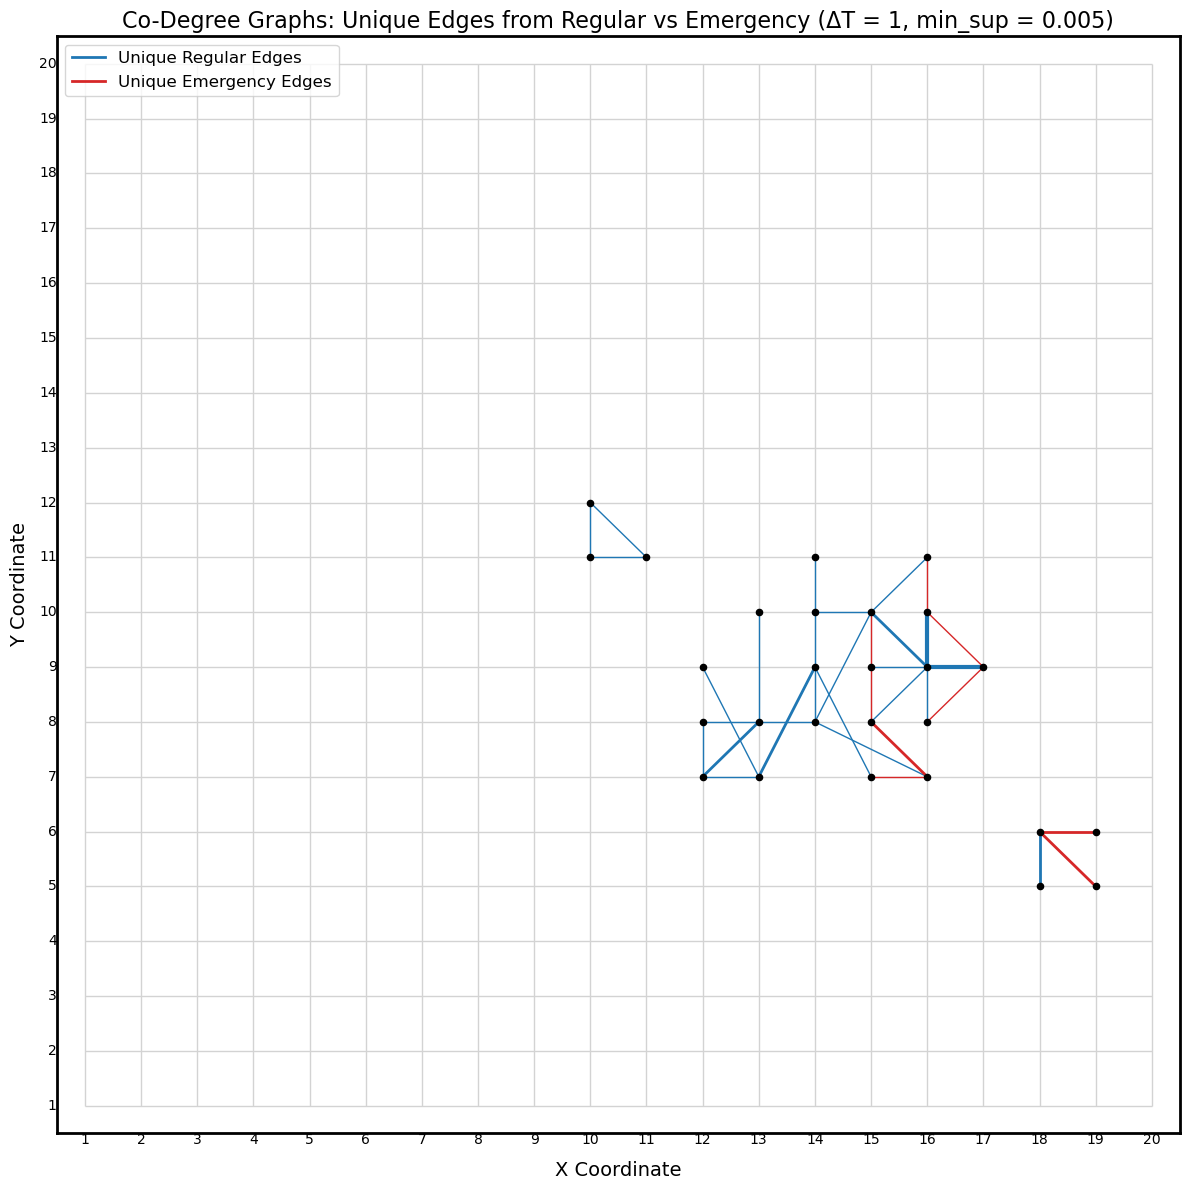

In [555]:
deltaT = 1
ms_ind = 0
min_he_size = 3 #co-degree only in higher-order interactions
grid_size = 20
threshold = 1
hyperedges_reg = get_hyperedges(deltaT, ms_ind, "regular", min_he_size)
hyperedges_emg = get_hyperedges(deltaT, ms_ind, "emergency", min_he_size)
co_degree_reg = compute_co_degree(hyperedges_reg, grid_size)
co_degree_emg = compute_co_degree(hyperedges_emg, grid_size)
plot_unique_edges_in_co_degree_graphs(co_degree_reg, co_degree_emg, grid_size, threshold, deltaT, ms_ind)

(regular, 3, 0): 3116/5018
(emergency, 3, 0): 2185/3861
max co_degree: 4


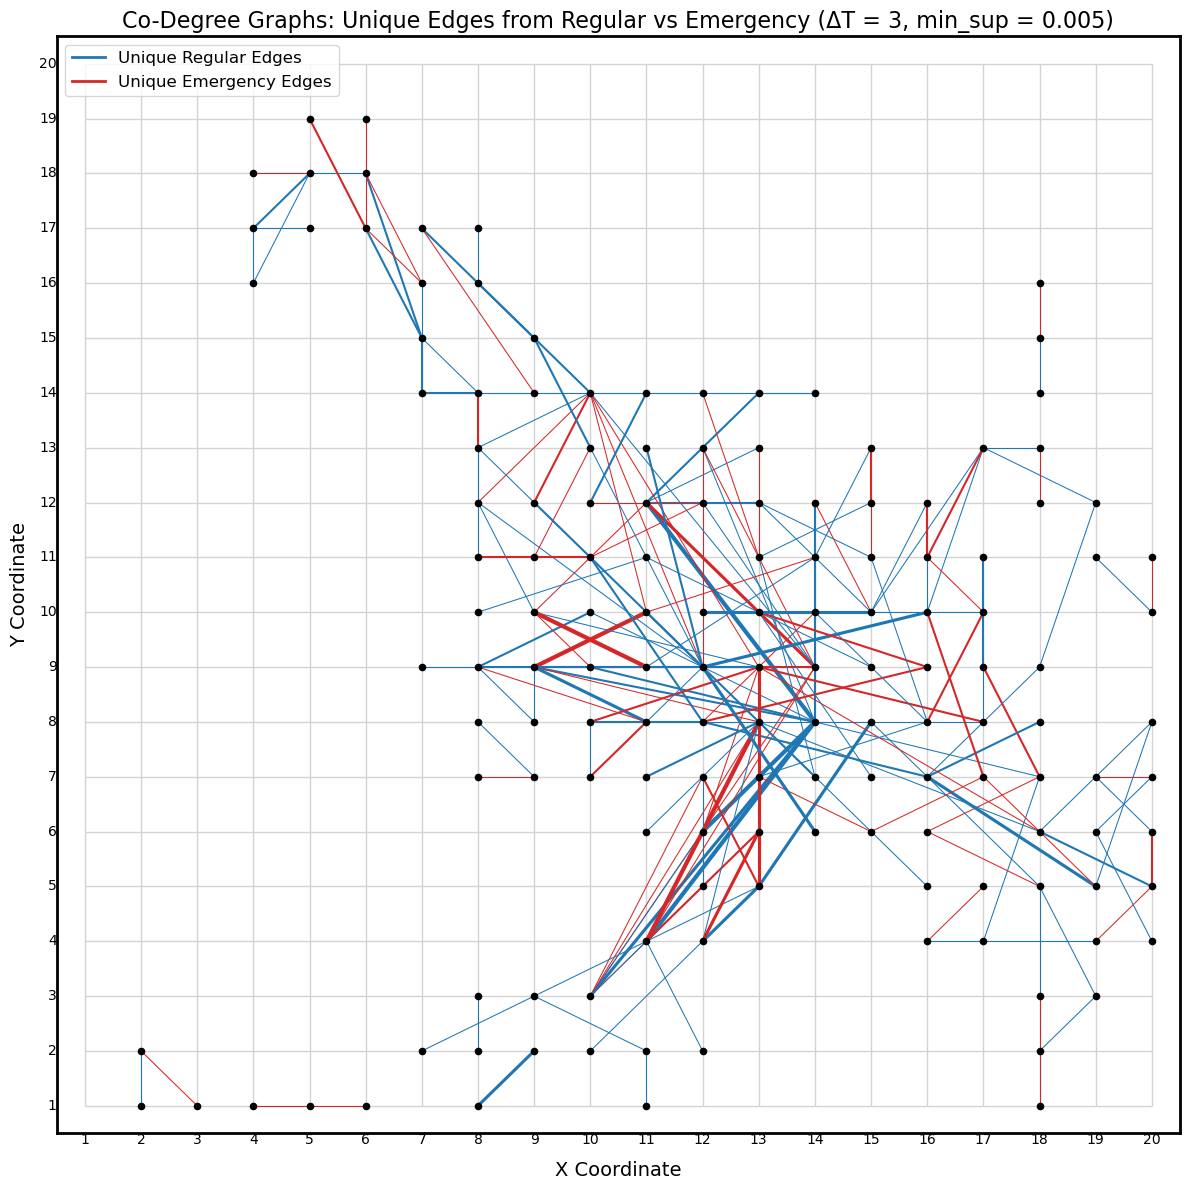

In [556]:
deltaT = 3
ms_ind = 0
min_he_size = 3 #co-degree only in higher-order interactions
grid_size = 20
threshold = 1
hyperedges_reg = get_hyperedges(deltaT, ms_ind, "regular", min_he_size)
hyperedges_emg = get_hyperedges(deltaT, ms_ind, "emergency", min_he_size)
co_degree_reg = compute_co_degree(hyperedges_reg, grid_size)
co_degree_emg = compute_co_degree(hyperedges_emg, grid_size)
plot_unique_edges_in_co_degree_graphs(co_degree_reg, co_degree_emg, grid_size, threshold, deltaT, ms_ind)

(regular, 7, 0): 66952/72181
(emergency, 7, 0): 43201/47945
max co_degree: 10


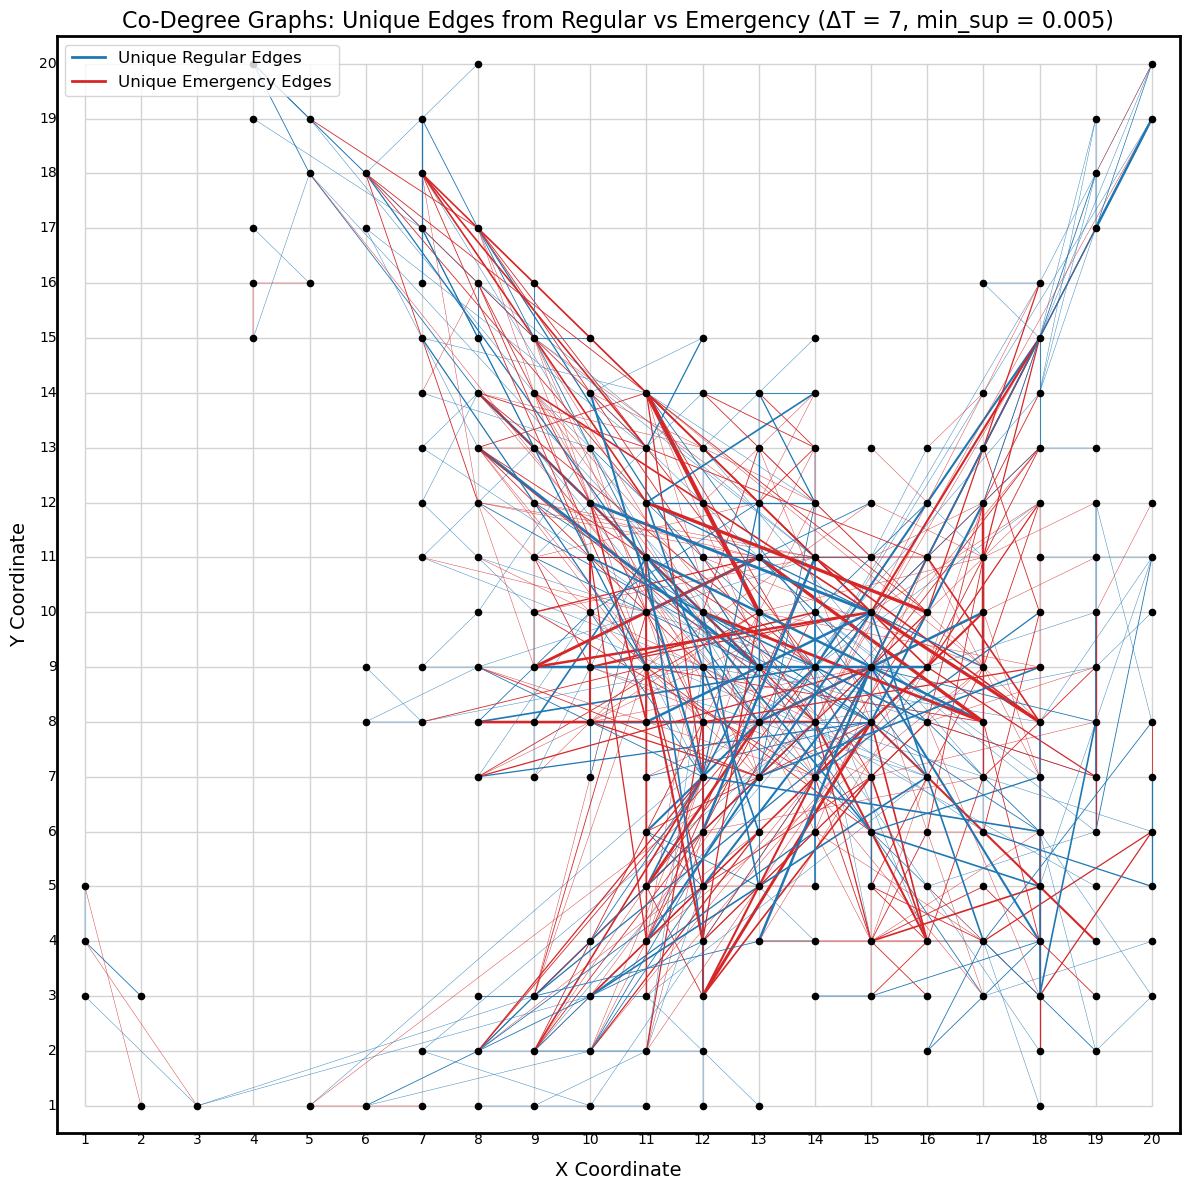

In [557]:
deltaT = 7
ms_ind = 0
min_he_size = 3 #co-degree only in higher-order interactions
grid_size = 20
threshold = 1
hyperedges_reg = get_hyperedges(deltaT, ms_ind, "regular", min_he_size)
hyperedges_emg = get_hyperedges(deltaT, ms_ind, "emergency", min_he_size)
co_degree_reg = compute_co_degree(hyperedges_reg, grid_size)
co_degree_emg = compute_co_degree(hyperedges_emg, grid_size)
plot_unique_edges_in_co_degree_graphs(co_degree_reg, co_degree_emg, grid_size, threshold, deltaT, ms_ind)

In [504]:
import itertools

def max_chebyshev_distance(H):
    """
    Computes the maximum Chebyshev distance of any node to its neighbors
    in a hypergraph.

    Parameters:
    H (Hypergraph): A hypergraph where nodes are represented by (x, y) coordinates.

    Returns:
    int: The maximum Chebyshev distance between any node and its neighbors.
    """
    max_chebyshev_distance = 0
    max_dist_string = ""

    for edge in H.edges:  # Iterate through all hyperedges
        # Extract the nodes in the hyperedge
        nodes = list(H.edges[edge].elements)  # Nodes as (x, y) tuples
        if len(nodes)<= 2:
            continue
        # Check all pairs of nodes in the hyperedge
        for (x1, y1), (x2, y2) in itertools.combinations(nodes, 2):
            # Co  mpute Chebyshev distance
            chebyshev_distance = max(abs(x1 - x2), abs(y1 - y2))
            # Update the maximum distance
            if chebyshev_distance > max_chebyshev_distance:
                print(f"{chebyshev_distance}, ({x1}, {y1}), ({x2}, {y2}), {nodes}")
                max_dist_string = f"{chebyshev_distance}, ({x1}, {y1}), ({x2}, {y2}), {nodes}"
            max_chebyshev_distance = max(max_chebyshev_distance, chebyshev_distance)
    
    return max_chebyshev_distance, max_dist_string

In [544]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a function to plot max L-infinity norm vs DeltaT for each min_sup as a bar plot
def plot_max_chebyshev_distance_bar(deltaT_vals, min_sups, HG_reg, HG_emg):
    """
    Plots the maximum Chebyshev distance (L-infinity norm) vs. DeltaT for each min_sup.
    Takes into account both regular and emergency hypergraphs, shown in a bar plot format.
    
    Parameters:
    deltaT_vals (list): List of DeltaT (time window size) values.
    min_sups (list): List of min_sup values.
    HG_reg (dict): Dictionary of regular hypergraphs indexed by DeltaT.
    HG_emg (dict): Dictionary of emergency hypergraphs indexed by DeltaT.
    """
    fw = open('chebyshev_dist_computation.txt', 'w')
    
    # Prepare a color palette suitable for colorblind viewers
    color_palette = sns.color_palette("colorblind", len(min_sups))
    
    # Initialize storage for results
    results_reg = {min_sup: [] for min_sup in min_sups}
    results_emg = {min_sup: [] for min_sup in min_sups}
    
    # Iterate over DeltaT and min_sup values
    for dT in deltaT_vals:
        H_dT_reg = HG_reg[dT]  # Regular hypergraphs for current DeltaT
        H_dT_emg = HG_emg[dT]  # Emergency hypergraphs for current DeltaT
        
        for i, min_sup in enumerate(min_sups):
            # Regular hypergraph
            H_reg = H_dT_reg[i]
            max_L_inf_norm_reg, max_dist_string_reg = max_chebyshev_distance(H_reg)
            results_reg[min_sup].append(max_L_inf_norm_reg)
            fw.write(f"Regular: {max_dist_string_reg}\n")
            fw.write(f"DeltaT={dT}, min_sup={min_sup}, Max Chebyshev Distance={max_L_inf_norm_reg}\n")
            fw.write("=============\n")
            
            # Emergency hypergraph
            H_emg = H_dT_emg[i]
            max_L_inf_norm_emg, max_dist_string_emg = max_chebyshev_distance(H_emg)
            results_emg[min_sup].append(max_L_inf_norm_emg)
            fw.write(f"Emergency: {max_dist_string_emg}\n")
            fw.write(f"DeltaT={dT}, min_sup={min_sup}, Max Chebyshev Distance={max_L_inf_norm_emg}\n")
            fw.write("=============\n")
    
    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define bar width and positions for the bars
    bar_width = 0.1  # Make the bars slimmer
    index = np.arange(len(deltaT_vals))  # X positions for bars

    # Set a small gap between the bars
    gap_1 = 0.15
    gap_0 = 0.1

    # Plot regular data as bars (with regular color)
    for i, min_sup in enumerate(min_sups):
        ax.bar(index + (i * (bar_width + gap_1)+gap_0), results_reg[min_sup], bar_width, label=f"{min_sup} (Regular)", 
               color=color_palette[i], alpha=0.7)

        # Plot emergency data as bars (with emergency color)
        ax.bar(index + (i * (bar_width + gap_1) +gap_0) + bar_width, results_emg[min_sup], bar_width, label=f"{min_sup} (Emergency)", 
               color=color_palette[i], alpha=0.7, hatch="\\")
    
    # Set labels and legend
    ax.set_xlabel(r"$\Delta T$ (Time Window Size)", fontsize=12, labelpad=10)
    ax.set_ylabel("Max Chebyshev Distance", fontsize=12, labelpad=10)
    ax.set_title("Maximum Chebyshev Distance Between Nodes in Hyperedges (Size $\geq$ 3)", fontsize=14)
    ax.set_xticks(index + bar_width*3+gap_0)
    ax.set_xticklabels(deltaT_vals, fontsize=12)
    ax.legend(title="$min\_sup$", fontsize=10, title_fontsize=11, loc="upper left")
    ax.grid(True, linestyle="--", alpha=0.6)

    # Customize the plot for better readability
    plt.tight_layout()
    plt.savefig('max_chebyshev_dist_bar_plot.png', dpi=600)

    # Show the plot
    plt.show()

    fw.close()


<>:72: DeprecationWarning: invalid escape sequence \g
<>:75: DeprecationWarning: invalid escape sequence \_
<>:72: DeprecationWarning: invalid escape sequence \g
<>:75: DeprecationWarning: invalid escape sequence \_
/var/folders/z0/wy551r2j0yx_cykzvy1n6hq40000gp/T/ipykernel_22713/505095726.py:72: DeprecationWarning: invalid escape sequence \g
  ax.set_title("Maximum Chebyshev Distance Between Nodes in Hyperedges (Size $\geq$ 3)", fontsize=14)
/var/folders/z0/wy551r2j0yx_cykzvy1n6hq40000gp/T/ipykernel_22713/505095726.py:75: DeprecationWarning: invalid escape sequence \_
  ax.legend(title="$min\_sup$", fontsize=10, title_fontsize=11, loc="upper left")


1, (14, 8), (14, 9), [(14, 8), (14, 9), (15, 7)]
2, (14, 9), (15, 7), [(14, 8), (14, 9), (15, 7)]
3, (14, 8), (14, 11), [(14, 8), (14, 9), (14, 11)]
1, (13, 8), (13, 9), [(13, 8), (13, 9), (14, 8)]
2, (13, 9), (13, 7), [(13, 8), (13, 9), (13, 7)]
1, (13, 9), (14, 9), [(13, 9), (14, 9), (14, 8)]
2, (14, 8), (14, 10), [(14, 8), (14, 9), (14, 10)]
1, (13, 9), (14, 9), [(13, 9), (14, 9), (14, 8)]
1, (13, 9), (14, 9), [(13, 9), (14, 9), (14, 8)]
2, (16, 7), (14, 9), [(16, 7), (14, 9), (15, 8)]
3, (12, 9), (15, 9), [(12, 9), (13, 7), (15, 9)]
4, (13, 7), (14, 11), [(13, 8), (13, 7), (14, 11)]
5, (13, 9), (10, 14), [(13, 9), (14, 9), (10, 14)]
6, (14, 9), (10, 3), [(14, 8), (14, 9), (10, 3)]
1, (13, 8), (13, 9), [(13, 8), (13, 9), (14, 8), (12, 9)]
2, (14, 8), (12, 9), [(13, 8), (13, 9), (14, 8), (12, 9)]
3, (15, 7), (12, 8), [(13, 8), (15, 7), (12, 8)]
4, (14, 7), (14, 11), [(14, 7), (14, 8), (14, 11)]
5, (12, 4), (14, 9), [(12, 4), (14, 8), (14, 9)]
2, (16, 7), (14, 8), [(16, 7), (14, 8), (

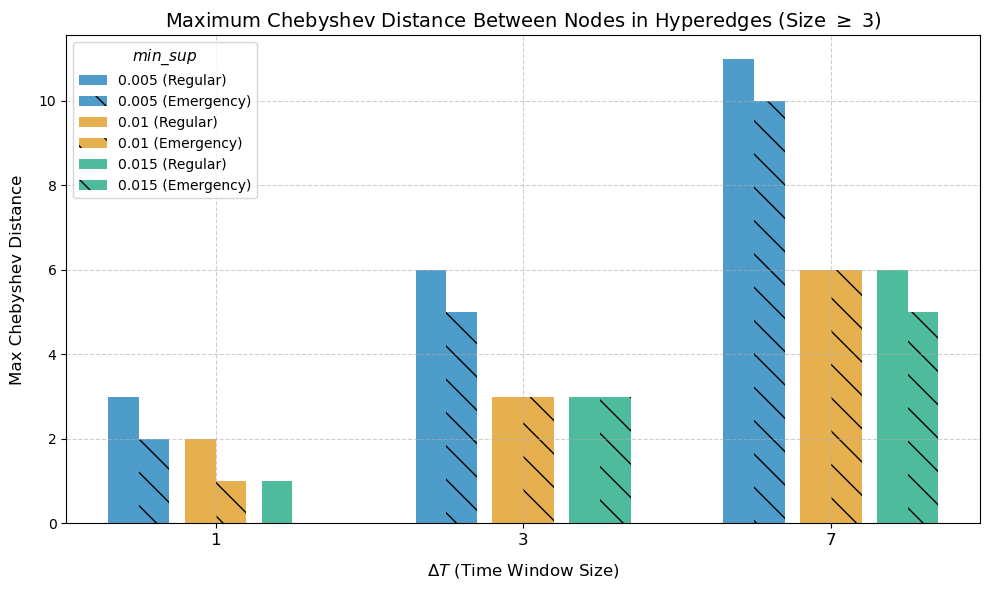

In [545]:
plot_max_chebyshev_distance_bar(deltaT_vals, min_sups, HG_reg, HG_emg)

1, (13, 8), (13, 9), [(13, 8), (13, 9), (14, 8)]
2, (13, 9), (13, 7), [(13, 8), (13, 9), (13, 7)]
1, (13, 9), (14, 9), [(13, 9), (14, 9), (14, 8)]
1, (13, 8), (13, 9), [(13, 8), (13, 9), (14, 8), (12, 9)]
2, (14, 8), (12, 9), [(13, 8), (13, 9), (14, 8), (12, 9)]
3, (15, 7), (12, 8), [(13, 8), (15, 7), (12, 8)]
4, (14, 7), (14, 11), [(14, 7), (14, 8), (14, 11)]
5, (12, 4), (14, 9), [(12, 4), (14, 8), (14, 9)]
1, (13, 8), (13, 9), [(13, 8), (13, 9), (14, 8), (12, 9)]
2, (14, 8), (12, 9), [(13, 8), (13, 9), (14, 8), (12, 9)]
3, (17, 6), (14, 8), [(16, 7), (17, 6), (14, 8)]
1, (13, 8), (13, 9), [(13, 8), (13, 9), (14, 8), (12, 9)]
2, (14, 8), (12, 9), [(13, 8), (13, 9), (14, 8), (12, 9)]
3, (14, 8), (14, 11), [(14, 8), (14, 9), (14, 11)]
1, (13, 8), (13, 9), [(13, 8), (13, 9), (14, 9), (14, 8)]
3, (16, 7), (13, 8), [(16, 7), (13, 8), (14, 8), (12, 9), (13, 9)]
4, (16, 7), (12, 9), [(16, 7), (13, 8), (14, 8), (12, 9), (13, 9)]
5, (10, 12), (15, 9), [(10, 12), (11, 11), (15, 9)]
6, (16, 9), 

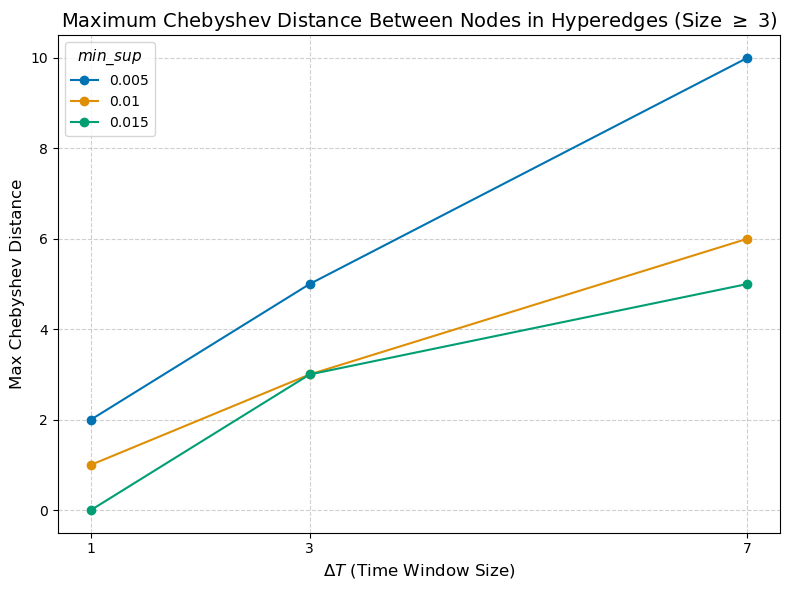

In [508]:
plot_max_chebyshev_distance(deltaT_vals, min_sups, HG_emg)

max co_degree: 5968


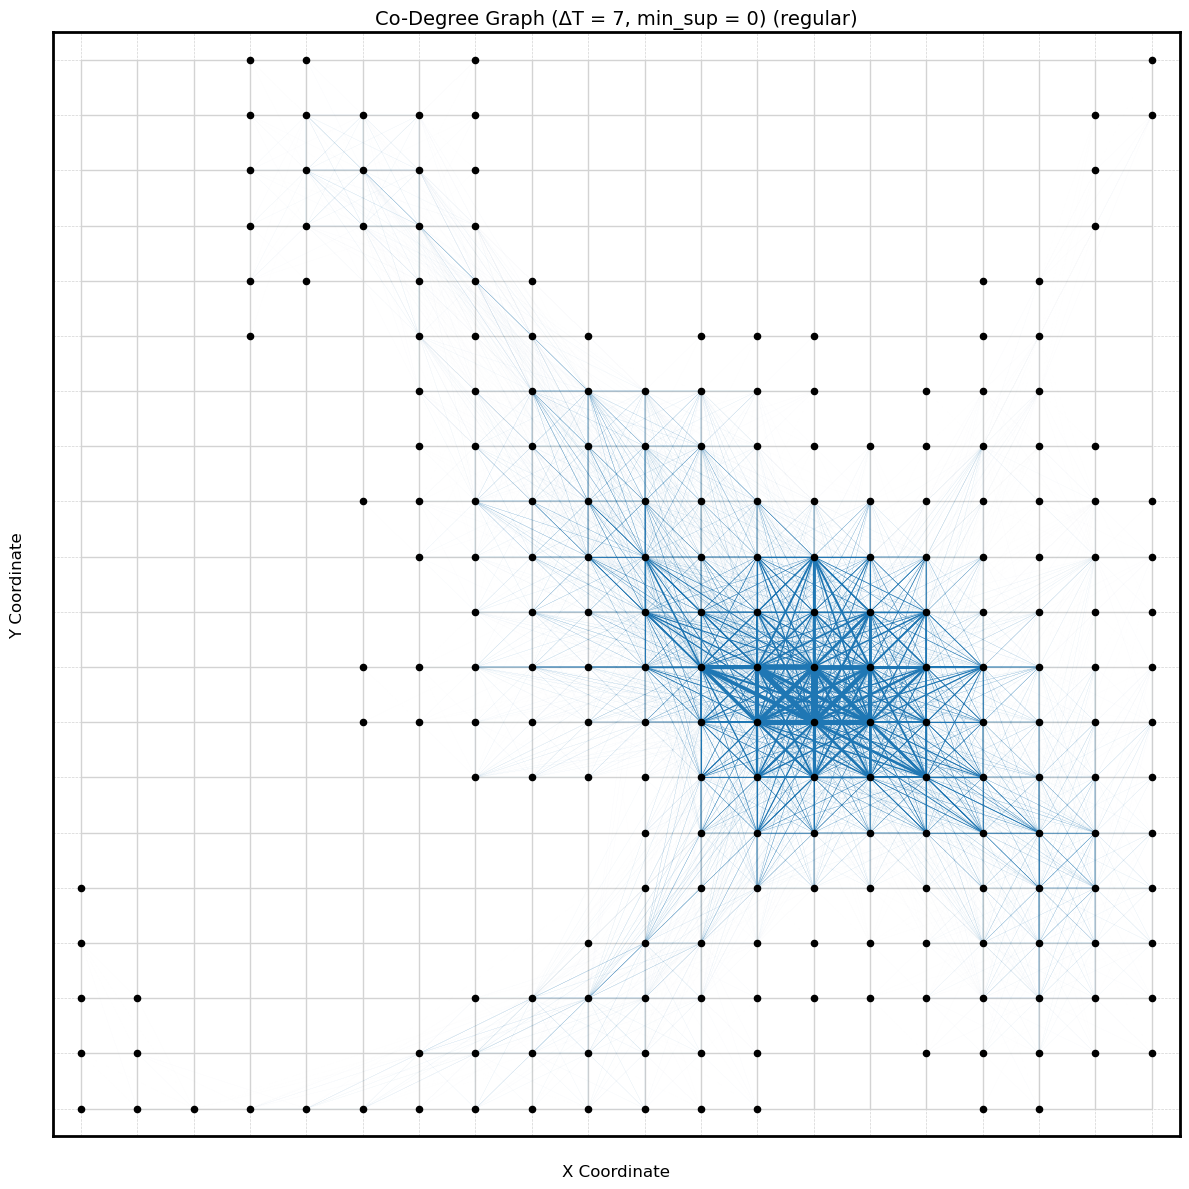

In [502]:
plot_single_co_degree_graph(co_degree_reg, grid_size, threshold, deltaT, ms_ind, "regular", title="Co-Degree Graph")

max co_degree: 5968


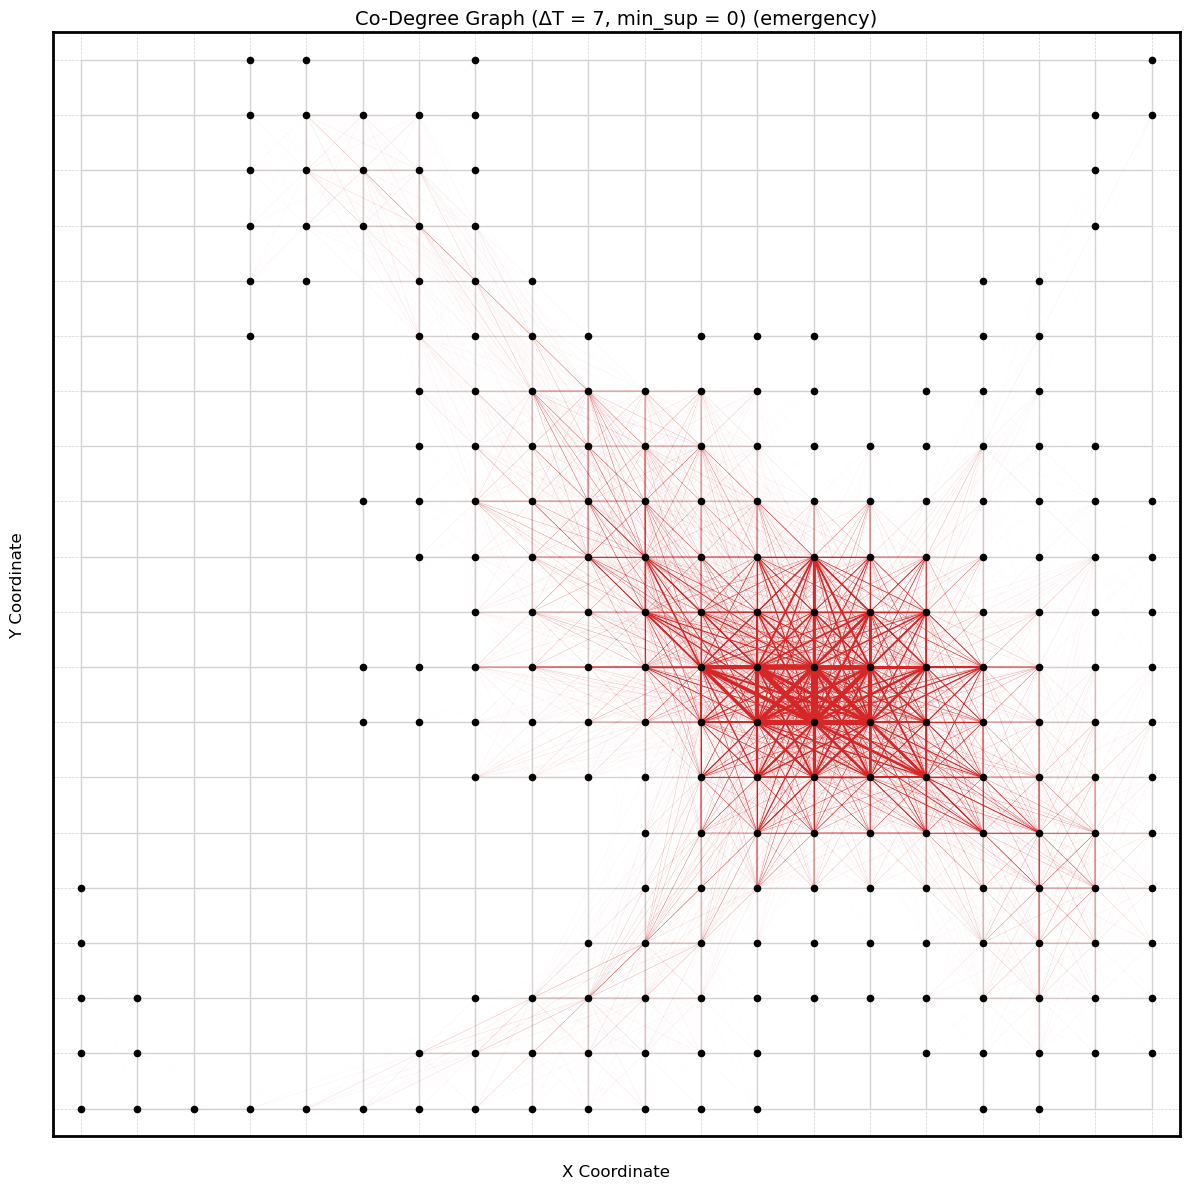

In [503]:
plot_single_co_degree_graph(co_degree_reg, grid_size, threshold, deltaT, ms_ind, "emergency", title="Co-Degree Graph")

In [452]:
deltaT = 3
ms_ind = 0
min_he_size = 3 #co-degree only in higher-order interactions
grid_size = 20
threshold = 1
hyperedges_reg = get_hyperedges(deltaT, ms_ind, "regular", min_he_size)
hyperedges_emg = get_hyperedges(deltaT, ms_ind, "emergency", min_he_size)
co_degree_reg = compute_co_degree(hyperedges_reg, grid_size)
co_degree_emg = compute_co_degree(hyperedges_emg, grid_size)

(regular, 3, 0): 3116/5018
(emergency, 3, 0): 2185/3861


max co_degree: 233


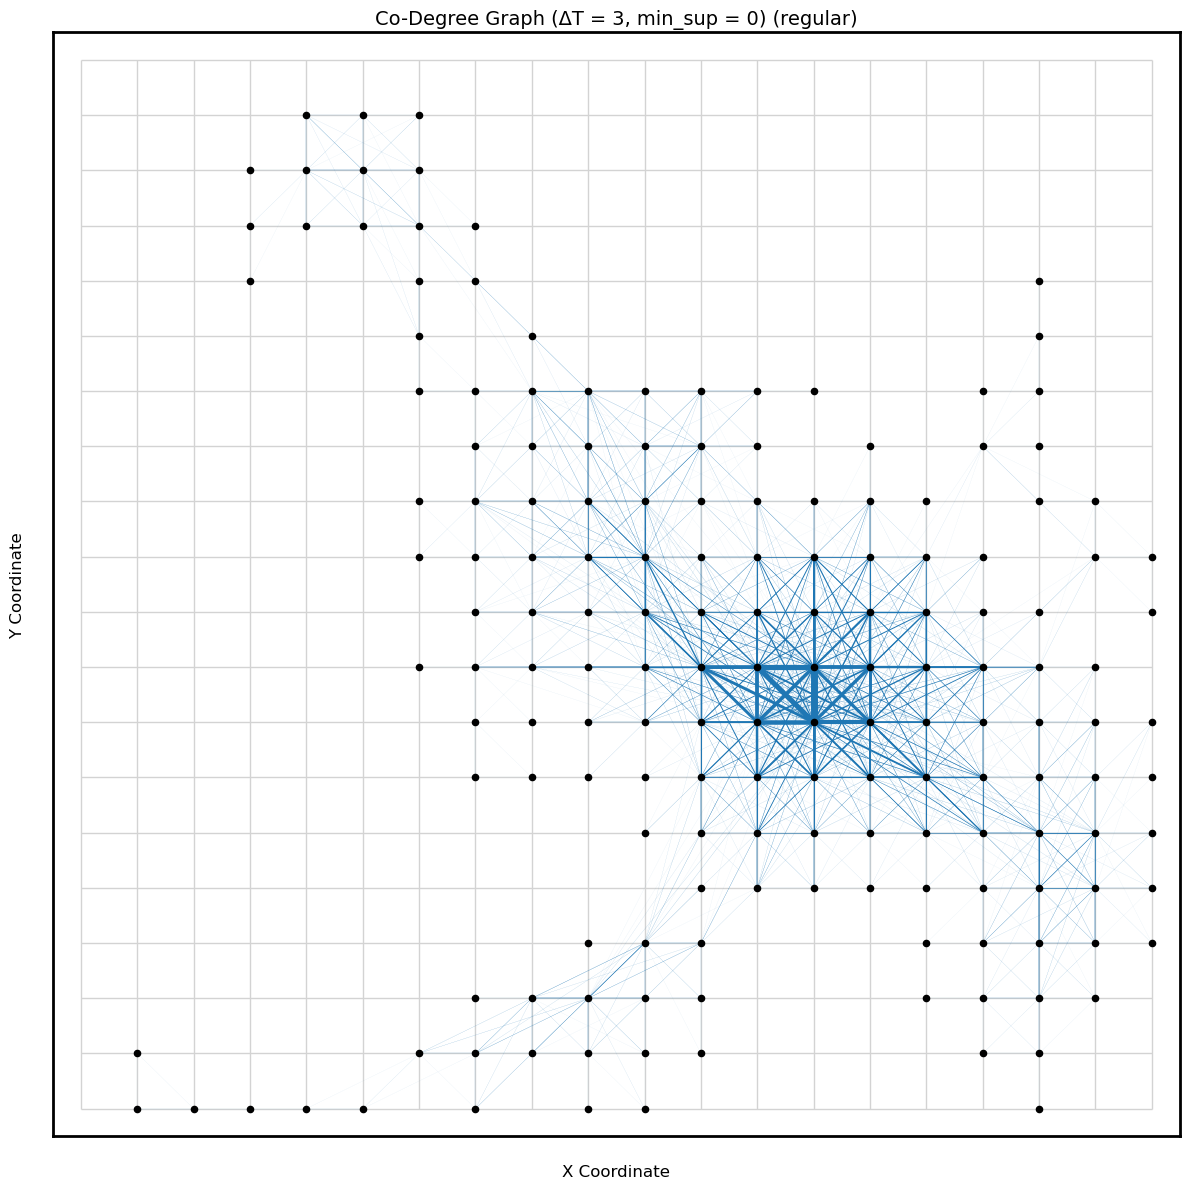

In [453]:
plot_single_co_degree_graph(co_degree_reg, grid_size, threshold, deltaT, ms_ind, "regular", title="Co-Degree Graph")

max co_degree: 233


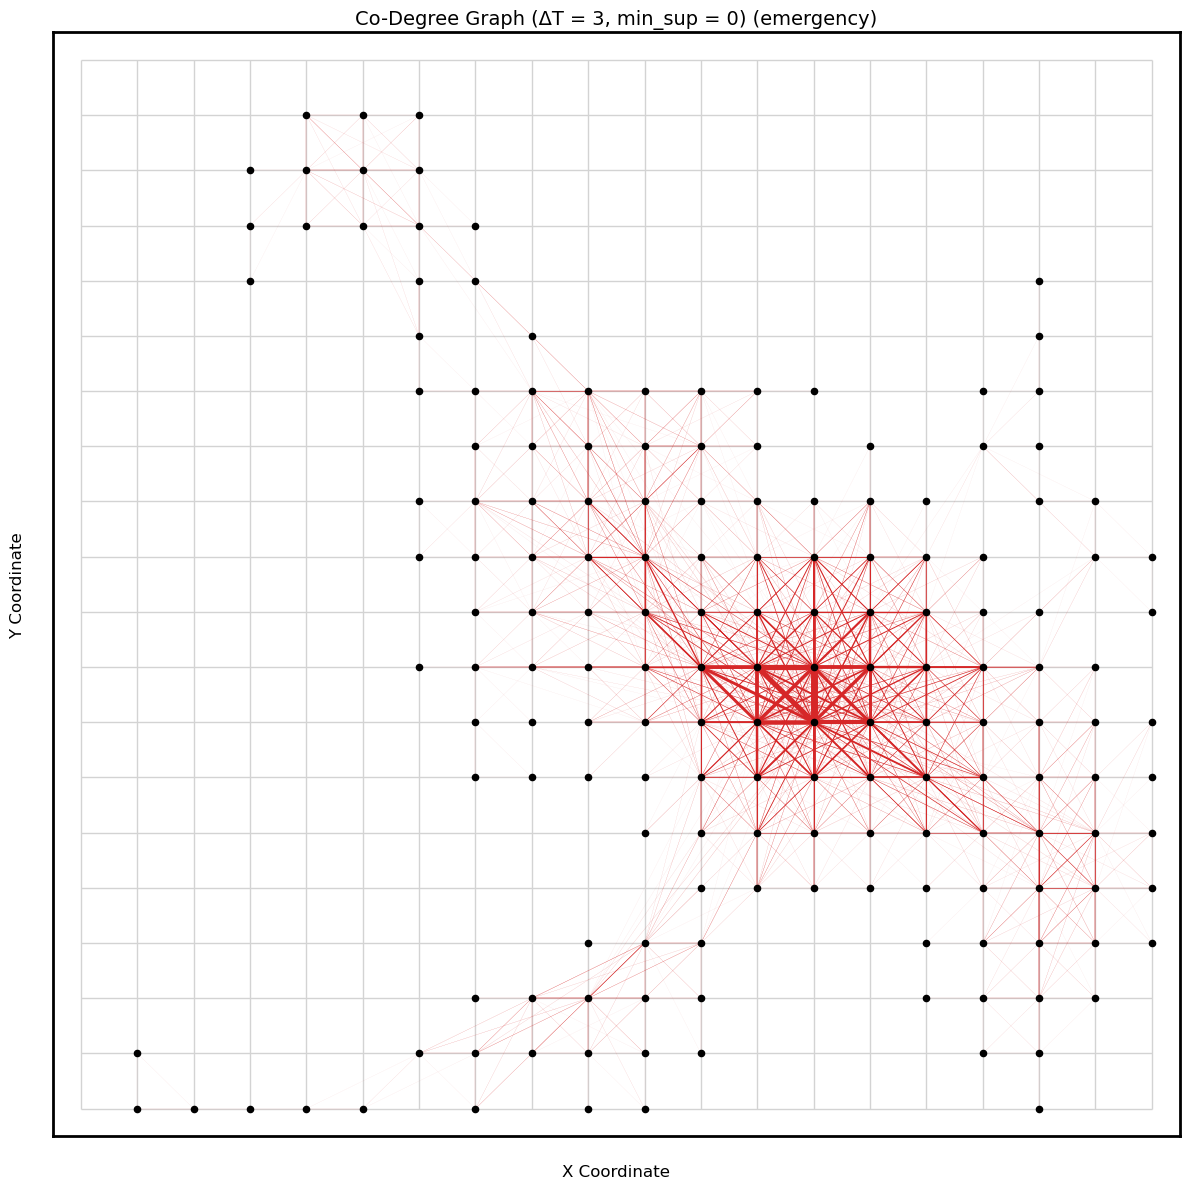

In [454]:
plot_single_co_degree_graph(co_degree_reg, grid_size, threshold, deltaT, ms_ind, "emergency", title="Co-Degree Graph")

In [455]:
deltaT = 7
ms_ind = 1
min_he_size = 3 #co-degree only in higher-order interactions
grid_size = 20
threshold = 1
hyperedges_reg = get_hyperedges(deltaT, ms_ind, "regular", min_he_size)
print(len(hyperedges_reg))
hyperedges_emg = get_hyperedges(deltaT, ms_ind, "emergency", min_he_size)
print(len(hyperedges_emg))
co_degree_reg = compute_co_degree(hyperedges_reg)
co_degree_emg = compute_co_degree(hyperedges_emg)
plot_co_degree_graphs_with_curved_edges(co_degree_reg, co_degree_emg, grid_size, threshold)

(regular, 7, 1): 10989/13470
10989
(emergency, 7, 1): 7280/9454
7280


TypeError: compute_co_degree() missing 1 required positional argument: 'grid_size'

In [ ]:
# Create a dictionary mapping (x, y) to node ids
node_id_map = {}

# Initialize node ID counter
node_id = 1

# Loop through each (x, y) coordinate in the grid from (1, 1) to (20, 20)
for x in range(1, 21):  # x goes from 1 to 20
    for y in range(1, 21):  # y goes from 1 to 20
        node_id_map[(x, y)] = node_id
        node_id += 1

# Print the dictionary for verification
print(len(node_id_map))

In [ ]:
def plot_k_uniform_subhypergraph(H, k, plot_path, DeltaT):
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)

    # Use node labels directly as (x, y) coordinates
    # Assuming H_order3 nodes are something like (0,0), (5,10), (10,5), etc.
    pos = {node: node for node in H.nodes}  # Node labels are used as positions

    node_labels_kwargs = {
        'fontsize': 10,         # Font size of the node labels
        'color': 'k',        # Color of the node labels
        'verticalalignment': 'top',  # Vertical alignment of the label
        'horizontalalignment': 'left' # Horizontal alignment of the label
    }
    # Draw the hypergraph using the node labels as positions and let edges be drawn normally
    hnx.draw(H, ax=ax, pos=pos, with_edge_labels=False, with_node_labels = True, node_radius=0.2,
         node_labels_kwargs=node_labels_kwargs)
    plot_title = f'{k}-uniform subhypergraph ($\Delta T =$ {DeltaT}, min_sup = {min_sups[0]})'
    plt.title(plot_title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(plot_path, dpi = 600)
    plt.show()

In [ ]:
DeltaT = 1
k = 3
min_sup_ind = 0
HG_deltaT_1 = HG[DeltaT]
k_uniform_edges = {edge: nodes for edge, nodes in HG_deltaT_1[min_sup_ind].incidence_dict.items() if len(nodes) == k}
print(len(k_uniform_edges))
H_k_uniform = hnx.Hypergraph(k_uniform_edges)
plot_path = f'hg_{k}_uniform_subgraph_deltaT_{DeltaT}_minsup_{min_sups[min_sup_ind]}.png'
plot_k_uniform_subhypergraph(H_k_uniform, k, plot_path, DeltaT)

In [ ]:
DeltaT = 3
k = 5
min_sup_ind = 0
HG_deltaT_1 = HG[DeltaT]
k_uniform_edges = {edge: nodes for edge, nodes in HG_deltaT_1[min_sup_ind].incidence_dict.items() if len(nodes) == k}
print(len(k_uniform_edges))
H_k_uniform = hnx.Hypergraph(k_uniform_edges)
plot_path = f'hg_{k}_uniform_subgraph_deltaT_{DeltaT}_minsup_{min_sups[min_sup_ind]}.png'
plot_k_uniform_subhypergraph(H_k_uniform, k, plot_path, DeltaT)

In [ ]:
DeltaT = 7
k = 7
min_sup_ind = 0
HG_deltaT_1 = HG[DeltaT]
k_uniform_edges = {edge: nodes for edge, nodes in HG_deltaT_1[min_sup_ind].incidence_dict.items() if len(nodes) == k}
print(k_uniform_edges)
H_k_uniform = hnx.Hypergraph(k_uniform_edges)
plot_path = f'hg_{k}_uniform_subgraph_deltaT_{DeltaT}_minsup_{min_sups[min_sup_ind]}.png'
plot_k_uniform_subhypergraph(H_k_uniform, k, plot_path, DeltaT)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

    
def plot_unique_edges_in_co_degree_graphs(co_degree_reg, co_degree_emg, grid_size, threshold, deltaT, ms_ind):
    """
    Creates and plots two co-degree graphs (regular and emergency) on the same grid with curved edges,
    where edges are color-coded to show only edges that are unique to either regular or emergency graphs.
    
    Parameters:
    co_degree_reg (dict): Co-degree dictionary for the regular graph (G_reg).
    co_degree_emg (dict): Co-degree dictionary for the emergency graph (G_emg).
    grid_size (int): Size of the spatial grid (e.g., 20 for a 20x20 grid).
    threshold (int): Minimum co-degree value to include an edge in the graph.
    deltaT (int): Temporal window value (for labeling).
    ms_ind (int): Index for the min_sup value.
    """

    # Create two graphs: one for regular (G_reg) and one for emergency (G_emg)
    G_reg = nx.Graph()
    G_emg = nx.Graph()

    # Add edges for regular graph with co-degree above the threshold
    for (node1, node2), weight in co_degree_reg.items():
        if weight >= threshold:
            G_reg.add_edge(node1, node2, weight=weight)

    # Add edges for emergency graph with co-degree above the threshold
    for (node1, node2), weight in co_degree_emg.items():
        if weight >= threshold:
            G_emg.add_edge(node1, node2, weight=weight)
    
    all_weights = []
    unique_reg_edges = []
    unique_emg_edges = []
    G_unique = nx.Graph()
    print("Unique Regular Edges")
    for edge in G_reg.edges():
        if edge not in G_emg.edges():
            print(edge)
            w = G_reg[edge[0]][edge[1]]['weight']
            all_weights.append(w)
            G_unique.add_edge(edge[0], edge[1], weight=w)
            unique_reg_edges.append(edge)
    print("Unique Emergency Edges")        
    for edge in G_emg.edges():
        print(edge)
        if edge not in G_reg.edges():
            w = G_reg[edge[0]][edge[1]]['weight']
            all_weights.append(w)
            G_unique.add_edge(edge[0], edge[1], weight=w)
            unique_emg_edges.append(edge)
        
    max_val = max(all_weights) if all_weights else 1 
    print(f"max co_degree: {max_val}")

    # Position nodes directly using their grid coordinates (x, y)
    pos = {node: (node[0], node[1]) for node in set(G_reg.nodes()).union(G_emg.nodes())}


    # Plot the graph with unique edges
    fig, ax = plt.subplots(figsize=(12, 12))
    
    
    # Define the grid size range from 1 to 20
    grid_min, grid_max = 1, 20
    grid_color = 'lightgray'

    # Set axis limits to ensure the grid is between 1 and 20, with a little padding for the box
    ax.set_xlim(grid_min - 0.5, grid_max + 0.5)
    ax.set_ylim(grid_min - 0.5, grid_max + 0.5)

    # Add grid lines from 1 to 20, ensuring they stay within the box
    ax.vlines(range(grid_min, grid_max + 1), grid_min, grid_max, color=grid_color, linestyle='-', linewidth=1, zorder=0)
    ax.hlines(range(grid_min, grid_max + 1), grid_min, grid_max, color=grid_color, linestyle='-', linewidth=1, zorder=0)

    # Add tick marks on the axes
    for i in range(grid_min, grid_max + 1):
        ax.text(i, grid_min - 0.5, str(i), ha='center', va='top', fontsize=10)  # X-axis labels
        ax.text(grid_min - 0.5, i, str(i), ha='right', va='center', fontsize=10)  # Y-axis labels


    # Plot edges with width proportional to the co-degree weight
    for node1, node2, data in G_unique.edges(data=True):
        weight = data['weight']
        x1, y1 = pos[node1]
        x2, y2 = pos[node2]
        # Scale the width by a factor of the weight (to make it proportional)
        width = weight / max_val  # Scale width by co-degree weight
        print(f"Edge: ({node1}, {node2}), Normalized Width: {width}, Weight: {weight}")

        # Plot curved edge using FancyArrowPatch with color based on the graph type
        if (node1, node2) in unique_reg_edges:
            edge_color = 'tab:blue'
        else:
            edge_color = 'tab:red'
        
        arrow = FancyArrowPatch((x1, y1), (x2, y2), connectionstyle="arc3,rad=0.2", 
                                edgecolor=edge_color, linewidth=weight * 0.8, alpha=1)
        ax.add_patch(arrow)

    # Plot nodes
    nx.draw_networkx_nodes(G_unique, pos, node_size=20, node_color='black', ax=ax)

    # Add grid lines and ensure tick labels are visible
    ticks = range(1, grid_size + 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(range(1, grid_size + 1), fontsize=10)
    ax.set_yticklabels(range(1, grid_size + 1), fontsize=10)
    ax.grid(which="both", color="lightgrey", linestyle="--", linewidth=0.5)
    ax.tick_params(axis='both', which='both', direction='in', length=5, width=0.5, colors='black')

    
    # Ensure the spines (top, bottom, left, right) are visible and have proper line width
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)  # Set the line width to make it more prominent
    # Customize the plot
    ax.set_title('Co-Degree Graphs: Unique Edges from Regular (Blue) vs Emergency (Red)', fontsize=14)
    ax.set_xlabel('X Coordinate', fontsize=12)
    ax.set_ylabel('Y Coordinate', fontsize=12)
    ax.axis('on')  # Turn on the axis for spatial clarity

    


    plt.grid(False)
    # Ensure the layout fits well
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'co_degree_graph_unique_edges_deltaT_{deltaT}_ms_{ms_ind}.png', dpi=600)

    # Show the plot
    plt.show()


In [ ]:
def is_moore_neighbour(node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    return abs(x1 - x2) <= 1 and abs(y1 - y2) <= 1

In [ ]:
def filter_edges_by_moore_neighborhood(hypergraph, r):
    filtered_edges = {}

    for edge_id, edge_nodes in hypergraph.incidence_dict.items():
        # Convert edge_nodes to a list of tuples if they aren't already
        edge_nodes = [tuple(node) if isinstance(node, (list, tuple)) else node for node in edge_nodes]
        
        # Check if all nodes in the edge are in each other's Moore neighborhood
        is_in_moore_neighborhood = True
        for node in edge_nodes:
            # For each node, get its Moore neighborhood
            neighbors = moore_neighborhood(*node)
            # Check if every other node in the edge is in this node's neighborhood
            if not all(other_node in neighbors for other_node in edge_nodes if other_node != node):
                is_in_moore_neighborhood = False
                break
        
        # If not all nodes are in each other's neighborhood, keep this edge
        if not is_in_moore_neighborhood:
            x = random.random()
            if x < r:
                filtered_edges[edge_id] = edge_nodes

    # Create a new hypergraph from the filtered edges
    return hnx.Hypergraph(filtered_edges), filtered_edges

In [ ]:
def strict_filter_edges(hypergraph, r):
    # Dictionary to store the filtered edges
    filtered_edges = {}
    
    for edge_id, nodes in hypergraph.incidence_dict.items():
        # Check all pairs in the hyperedge to ensure none are in each other's Moore neighborhood
        if all(not is_moore_neighbour(node1, node2) for node1, node2 in combinations(nodes, 2)):
            x = random.random()
            if x < r:
                filtered_edges[edge_id] = nodes  # Add the edge if it passes the Moore neighborhood check

    # Create a new hypergraph with the filtered edges
    filtered_hypergraph = hnx.Hypergraph(filtered_edges)
    return filtered_hypergraph, filtered_edges

In [ ]:
import random as random
from itertools import combinations


def create_difference_hypergraph_edges_filter_non_moore_neighbourhood(HG, DT1, DT2, k, ms1, ms2, r):
    hg_edges_k_uniform_1 = {edge: nodes for edge, nodes in HG[DT1][ms1].incidence_dict.items() if len(nodes) == k} 
    hg_edges_k_uniform_2 = {edge: nodes for edge, nodes in HG[DT2][ms2].incidence_dict.items() if len(nodes) == k}

    print(len(hg_edges_k_uniform_1), len(hg_edges_k_uniform_2))
    #print(hg_edges_k_uniform_1)
    
    edges_set_1 = set(frozenset(nodes) for nodes in hg_edges_k_uniform_1.values())
    edges_set_2 = set(frozenset(nodes) for nodes in hg_edges_k_uniform_2.values())
    # Compute exclusive edges in HG2 but not in HG1
    exc_edges = edges_set_2 - edges_set_1
    print("Number of exclusive edges before filtering:", len(exc_edges))
    exclusive_hg = hnx.Hypergraph({f"e{j}": list(edge) for j, edge in enumerate(exc_edges)})
    print(f"Before filtering number of exclusive edges: {len(exc_edges)}")
    #exclusive_hg_filtered, filtered_exc_edges = filter_edges_by_moore_neighborhood(exclusive_hg, r)
    exclusive_hg_filtered, filtered_exc_edges = strict_filter_edges(exclusive_hg, r)
    
    #print(filtered_exc_edges)
    # Print the final count of selected edges for confirmation
    print(f"Final count of edges after filtering and random selection: {len(filtered_exc_edges)}")

    return exclusive_hg_filtered

In [ ]:
DT1 = 3
DT2 = 7
k = 4
ms1 = 0
ms2 = 0
r = 0.75
diff_HG = create_difference_hypergraph_edges_filter_non_moore_neighbourhood(HG, DT1, DT2, k, ms1, ms2, r)

In [ ]:
plot_path = f'test.png'
plot_k_uniform_subhypergraph(diff_HG, k, plot_path, DeltaT)

In [ ]:
DeltaT = 1
k = 3
min_sup_ind = 0
HG_deltaT_1 = HG[DeltaT]
k_uniform_edges = {edge: nodes for edge, nodes in HG_deltaT_1[min_sup_ind].incidence_dict.items() if len(nodes) == k}
print(len(k_uniform_edges))
HG_1 = hnx.Hypergraph({f"e{j}": list(edge) for j, edge in enumerate(k_uniform_edges)})

In [ ]:
DeltaT = 3
k = 3
min_sup_ind = 1
HG_deltaT_1 = HG[DeltaT]
k_uniform_edges_1 = {edge: nodes for edge, nodes in HG_deltaT_1[min_sup_ind].incidence_dict.items() if len(nodes) == k}
print(len(k_uniform_edges_1))
HG_2 = hnx.Hypergraph({f"e{j}": list(edge) for j, edge in enumerate(k_uniform_edges_1)})

In [ ]:
diff_HG = create_difference_hypergraph_edges(k_uniform_edges, k_uniform_edges_1)
k_uniform_edges_diff = {edge: nodes for edge, nodes in diff_HG.incidence_dict.items() if len(nodes) == k}
print(k_uniform_edges_diff)
plot_path = f'test.png'
plot_k_uniform_subhypergraph(diff_HG, k, plot_path, DeltaT)

In [ ]:
import hypernetx as hnx
import hypergraphx as hgx
from hypergraphx.measures.eigen_centralities import CEC_centrality

def convert_hypernetx_to_hypergraphx(hnx_hypergraph):
    """
    Converts a HyperNetX hypergraph to a HypergraphX hypergraph.
    Maps original node labels (x, y) to sequential integer indices used in HypergraphX.
    
    Parameters:
    hnx_hypergraph (HyperNetX Hypergraph): The original HyperNetX hypergraph.
    
    Returns:
    hgx_hypergraph (HypergraphX Hypergraph): The converted HypergraphX hypergraph.
    node_mapping (dict): Mapping from HypergraphX indices to original node labels.
    """
    hgx_hypergraph = hgx.Hypergraph()
    node_mapping = {}

    # Create a node mapping: (x, y) to HyperGraphX index
    node_idx = 0  # Start with index 0 for HyperGraphX nodes
    for node in hnx_hypergraph.nodes:
        hgx_hypergraph.add_node(node_idx)
        node_mapping[node_idx] = node  # Map HyperGraphX index to (x, y) coordinate
        node_idx += 1

    # Add hyperedges, using the node indices mapped from (x, y) coordinates
    for edge, nodes in hnx_hypergraph.incidence_dict.items():
        # Map each (x, y) node to the corresponding HyperGraphX index
        edge_nodes = [idx for idx, node in enumerate(hnx_hypergraph.nodes) if node in nodes]
        hgx_hypergraph.add_edge(edge_nodes)  # Add the edge with integer indices

    return hgx_hypergraph, node_mapping

In [ ]:
hgx_H_k_uniform, node_mapping = convert_hypernetx_to_hypergraphx(H_k_uniform)

In [ ]:
centrality_dict = CEC_centrality(hgx_H_k_uniform)

# Remap centrality_dict to use original labels
original_centrality_dict = {node_mapping[node]: score for node, score in centrality_dict.items()}

# Print results with original node labels
for node, score in original_centrality_dict.items():
    print(f"Node {node}: CEC Centrality = {score}")


In [ ]:
centrality_dict

In [ ]:
hgx_H_k_uniform.get_nodes()

In [ ]:
DeltaT = 7
k = 7
min_sup_ind = 0
HG_deltaT_1 = HG[DeltaT]
hgx_H_k_uniform, node_mapping = convert_hypernetx_to_hypergraphx(HG_deltaT_1[0])
motifs = compute_motifs(hgx_H_k_uniform, order=3, runs_config_model=10)

In [ ]:
motifs